$
Code d'analyse de tracking. Il permet de récupérer les fichiers issus du tracking et d'en tirer les trajectoires pertinentes et d'en faire l'étude statistique. 

In [385]:
%reset

In [386]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Mar  1 12:46:56 2023.

@author: souchaud
"""
# %%
import os
import time
import math
import pandas as pd
import numpy as np
from skimage import io
from PIL import Image
from scipy.stats import norm
from scipy import stats
from scipy.signal import find_peaks
from scipy.optimize import curve_fit, minimize_scalar
import imageio
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.collections import LineCollection
import matplotlib.gridspec as gridspec
import trackpy as tp
import functions_analyze as lib
import warnings
import importlib
from collections import defaultdict
from colorama import init, Fore, Style
from typing import List, Optional, Union, Any, Dict, Tuple
importlib.reload(lib)

init(autoreset=True)
# from matplotlib.cm import ScalarMappable
# import pdb; pdb.set_trace()
# warnings.simplefilter("always")  # This will always display warnings
# warnings.simplefilter('error', RuntimeWarning)
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)

Initialisation des variables et constantes de travail.

In [387]:
# set initial time
INITIAL_TIME = time.time()

# experiment parameters
TIME_FRAME = 15 # 15  # 75
SIZE_PIX = 0.637# 1.2773  # 1.634  # 4.902
FPS = 1/TIME_FRAME

# File to study
file_name = 'features' # 'features'  # 'filtered'Any
# number of frame kept
N_FRAME = 1
N_FRAME_MIN_STUDY = 100  # Nombre minimal de frame sur laquelle la cellule doit être suivie

# nber hours of stydy:
LONG_TIME = False

# Study parameters
ROLLING_MEAN = False
PIXELISATION = False
TIME_FRAME_STUDY = False
DRIFT = False

# plot parameters
IMG_TYPE = 'jpg'
ALPHA = 0.5
LINEWIDTH = 0.1
COLOR_SUP = 'blue'
COLOR_INF = 'red'
color_sup_inf = (COLOR_SUP, COLOR_INF)

# % de présences de la particules sur le total de frame étudiées

FRAME_PARTICULE = 1

# ##########
# % de présences des courbes dans les frames

FRAME_PARTICULE = 0.8

Définition des path et dossiers de travails / enregistrements.

In [388]:
# ##########################   GENERAL PATH   #################################
GENERAL_PATH = '/Users/souchaud/Desktop/Analyses/'
GENERAL_PATH_PICTURES = '/Users/souchaud/Desktop/A_analyser/'
# GENERAL_PATH_PICTURES = '/Volumes/Labo_Alex_Mac/A_analyser/'

In [389]:
############# CONDITION SIMPLE ################
# CONDITION_simple = 'CytoOne_SorC'
# CONDITION_simple = 'NonT_SorC'
CONDITION_simple = 'CytoOne_HL5_10x'
CONDITION_simple= 'Comparaison_fiji_trackpy'
# CONDITION_simple = 'CytoOne_HL5'

############### CONDITION ################
CONDITION = f'{CONDITION_simple}_new_param' # _longtime_new_param'
# CONDITION = 'ASMOT035_fiji'
###########################################

In [390]:
# list of pathway to the experiments
PATHWAY_EXPERIMENT = []

if len(PATHWAY_EXPERIMENT) == 0:
    PATHWAY_EXPERIMENT = [f for f in os.listdir(GENERAL_PATH + CONDITION) if
                          os.path.isdir(os.path.join(GENERAL_PATH + CONDITION, f))]
# ##########################   Path Exp final  ###############################

PATHWAY_EXPERIMENT = [f'{GENERAL_PATH}{CONDITION}/' +
                      elem + '/mosaic/' for elem in PATHWAY_EXPERIMENT]

# ##########################   Path to Save pic  ##############################

path_save_pic = f'{GENERAL_PATH}résultats_{CONDITION}_ALL_OK_x5_15s/'

# création d'un dossier spécific d'enregistrement.
if not os.path.exists(path_save_pic):
    os.mkdir(path_save_pic)
os.chdir(path_save_pic)

Lecture des données expériementales

In [391]:
importlib.reload(lib)
DATA = lib.read_hdf5_all(pathway_experiment=PATHWAY_EXPERIMENT, name_file=file_name,
                         nbr_frame_min=N_FRAME_MIN_STUDY, condition=CONDITION, drift=DRIFT,
                         search_range=20, memory=5)

Frame 339: 67 trajectories present.
ASMOT109  :  60
['/Users/souchaud/Desktop/Analyses/Comparaison_fiji_trackpy_new_param/2023_12_07_ASMOT901_AX3_P0_x10_15x_CytoOne_HL5/mosaic/features.hdf5']
ASMOT901  :  59
Nombre de particules récoltées avant tri:  119


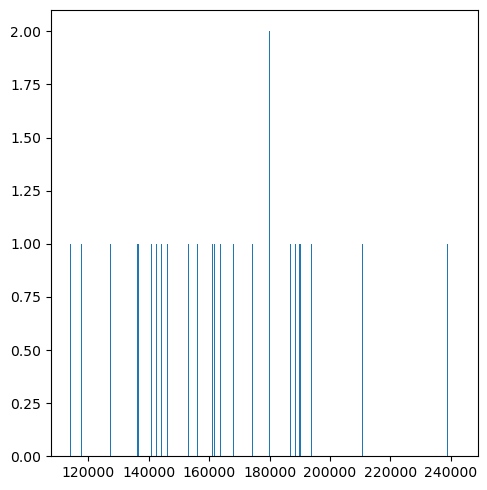

In [392]:
df = DATA[DATA['experiment'] == 'ASMOT109']
d0 = df #[df['frame']==0]
fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(d0.groupby('particle')['raw_mass'].mean(), bins=1000)
fig.tight_layout()

On décide de travailler que sur un certain nombre de frame. Ici je décide de travailler sur les 240 première frames. 
Donc la cellules doit être suivi sur N_MIN_STUDY sur les 240 premières frames. 

In [393]:
print("Nombre de particule avant tri: ", DATA['particle'].nunique())
DATA = DATA[DATA['frame'] < 340]

filter_data = DATA.groupby('particle').filter(lambda x: len(x) >= N_FRAME_MIN_STUDY)
print("Nombre de particule après le premier tri sur le temps suivi des cellules: ", filter_data['particle'].nunique())
DATA = filter_data

Nombre de particule avant tri:  119
Nombre de particule après le premier tri sur le temps suivi des cellules:  119


In [394]:
DATA['time (min)'] = DATA['frame']*TIME_FRAME/60
DATA = lib.vit_instant_new(traj=DATA, lag_time=TIME_FRAME, pix_size=SIZE_PIX, triage=1)

In [395]:
DATA = DATA.query(f'frame % {N_FRAME} == 0')
DATA['frame'] = pd.factorize(DATA['frame'])[0]
FPS = FPS/N_FRAME
DATA

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,old_particle,count,particle,experiment,position,condition,time (min),dx [pix],dy [pix],displacement [pix],VitInst [um/min]
0,95.964718,5239.625082,29101.271983,15.492201,0.162321,31.462237,170122.0,0.018166,0,0,196,0,ASMOT109,/Users/souchaud/Desktop/Analyses/Comparaison_f...,Comparaison_fiji_trackpy_new_param,0.00,NaN,NaN,NaN,NaN
1,93.953449,5239.591497,30279.806563,15.828454,0.199527,31.597165,178569.0,0.010001,1,0,196,0,ASMOT109,/Users/souchaud/Desktop/Analyses/Comparaison_f...,Comparaison_fiji_trackpy_new_param,0.25,-0.033585,-2.011269,2.011550,5.125429
2,91.165022,5239.670602,30640.047007,15.775771,0.205130,32.667100,178165.0,0.005252,2,0,196,0,ASMOT109,/Users/souchaud/Desktop/Analyses/Comparaison_f...,Comparaison_fiji_trackpy_new_param,0.50,0.079105,-2.788427,2.789548,7.107769
3,88.036935,5239.540423,30089.268469,15.368300,0.176825,33.445101,170144.0,0.000642,3,0,196,0,ASMOT109,/Users/souchaud/Desktop/Analyses/Comparaison_f...,Comparaison_fiji_trackpy_new_param,0.75,-0.130178,-3.128087,3.130795,7.977265
4,85.589492,5238.892710,28429.328318,14.743914,0.122961,33.204030,159555.0,0.001095,4,0,196,0,ASMOT109,/Users/souchaud/Desktop/Analyses/Comparaison_f...,Comparaison_fiji_trackpy_new_param,1.00,-0.647713,-2.447443,2.531701,6.450773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36533,8580.774391,6013.894065,NaN,NaN,NaN,NaN,NaN,NaN,318,69,135,118,ASMOT901,/Users/souchaud/Desktop/Analyses/Comparaison_f...,Comparaison_fiji_trackpy_new_param,79.50,2.551597,-1.883251,3.171322,8.080529
36534,8578.576176,6017.622737,NaN,NaN,NaN,NaN,NaN,NaN,319,69,135,118,ASMOT901,/Users/souchaud/Desktop/Analyses/Comparaison_f...,Comparaison_fiji_trackpy_new_param,79.75,3.728672,-2.198215,4.328412,11.028793
36535,8576.162446,6021.322612,NaN,NaN,NaN,NaN,NaN,NaN,320,69,135,118,ASMOT901,/Users/souchaud/Desktop/Analyses/Comparaison_f...,Comparaison_fiji_trackpy_new_param,80.00,3.699875,-2.413730,4.417597,11.256038
36536,8574.374676,6024.284344,NaN,NaN,NaN,NaN,NaN,NaN,321,69,135,118,ASMOT901,/Users/souchaud/Desktop/Analyses/Comparaison_f...,Comparaison_fiji_trackpy_new_param,80.25,2.961732,-1.787770,3.459477,8.814746


In [396]:
# # In[Filter on mass]
# if 'mass' in DATA.columns:
#     mask = DATA.groupby('particle')['mass'].transform('mean') >= 1000
#     DATA = DATA[mask]
# if 'level_0' in DATA.columns:
#     DATA = DATA.drop('level_0', axis=1)
# DATA.reset_index(inplace=True)
# # In[Compute some datas as instant displacement /speed / centering trajectories ...]


On trace le nombre de particules par frame en fonction du temps pour chaque manips. Ca permets de repérer des anomalies. 

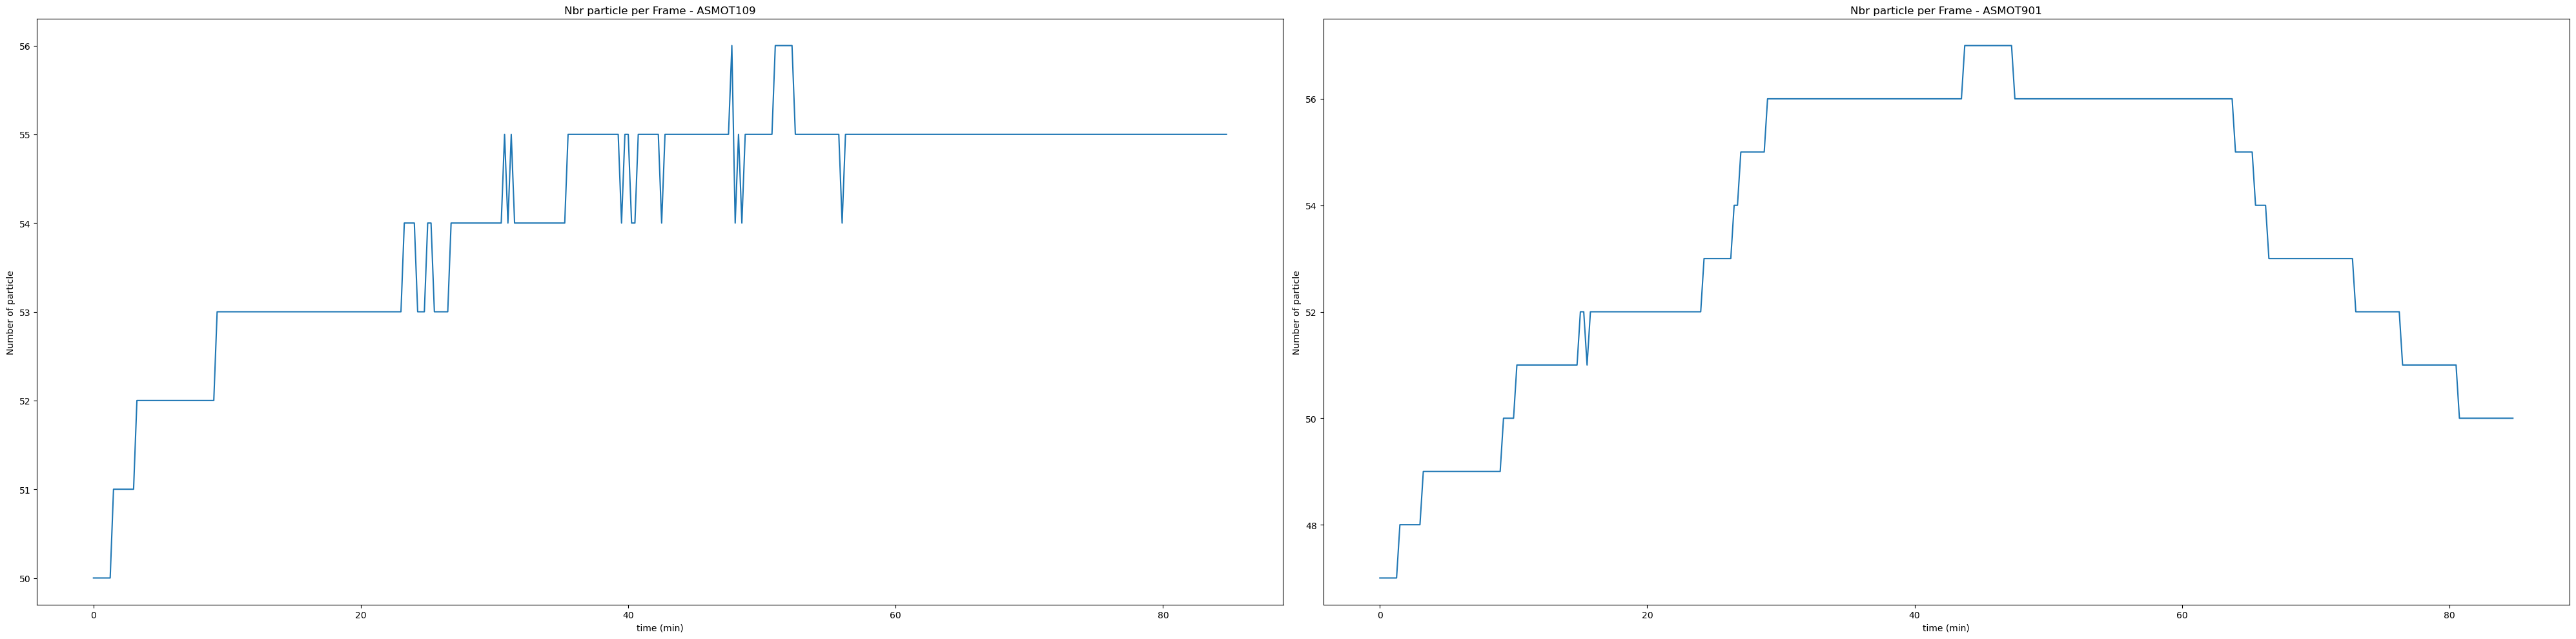

In [397]:
# Obtenir les expériences uniques pour les itérations
experiments = DATA['experiment'].unique()

# Déterminer le nombre de lignes et de colonnes pour les sous-graphiques
# Vous pouvez ajuster cela en fonction du nombre total d'expériences
n_cols = 2  # Nombre de colonnes, ajustez selon le besoin
n_rows = (len(experiments) + n_cols - 1) // n_cols  # Nombre de lignes

# Créer une figure et des axes pour les sous-graphiques
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20 * n_cols, 10 * n_rows))
axs = axs.flatten()  # Aplatir le tableau d'axes si nécessaire

# Tracer les graphiques pour chaque expérience
for i, exp in enumerate(experiments):
    # Grouper les données par 'frame' et calculer le nombre de particules par frame
    nbr_part_per_frame = DATA[DATA['experiment'] == exp].groupby('time (min)')['particle'].nunique()

    # Tracer le graphique sur le sous-graphique correspondant
    ax = axs[i]
    ax.plot(nbr_part_per_frame.index, nbr_part_per_frame.values)
    ax.set_title(f'Nbr particle per Frame - {exp}')
    ax.set_xlabel('time (min)')
    ax.set_ylabel('Number of particle')
    # ax.set_xlim([0, 340])
    # ax.set_ylim([0, 2000])  # Ajustez selon vos données

# Masquer les axes non utilisés s'il y en a
for ax in axs[len(experiments):]:
    ax.axis('off')

# Ajustement de la mise en page
plt.tight_layout()
# Ajustement de l'espacement et des marges
# plt.subplots_adjust(hspace=0.4, wspace=0.4)
# Enregistrer la figure entière
plt.savefig(f"{path_save_pic}Nbr_particle_per_Frame_manip_par_manip.jpg", format='jpg')

# Afficher la figure
plt.show()


In [398]:
# Example usage
path_data = lib.calculate_total_path_first_frames(DATA, first_n_frames=100)

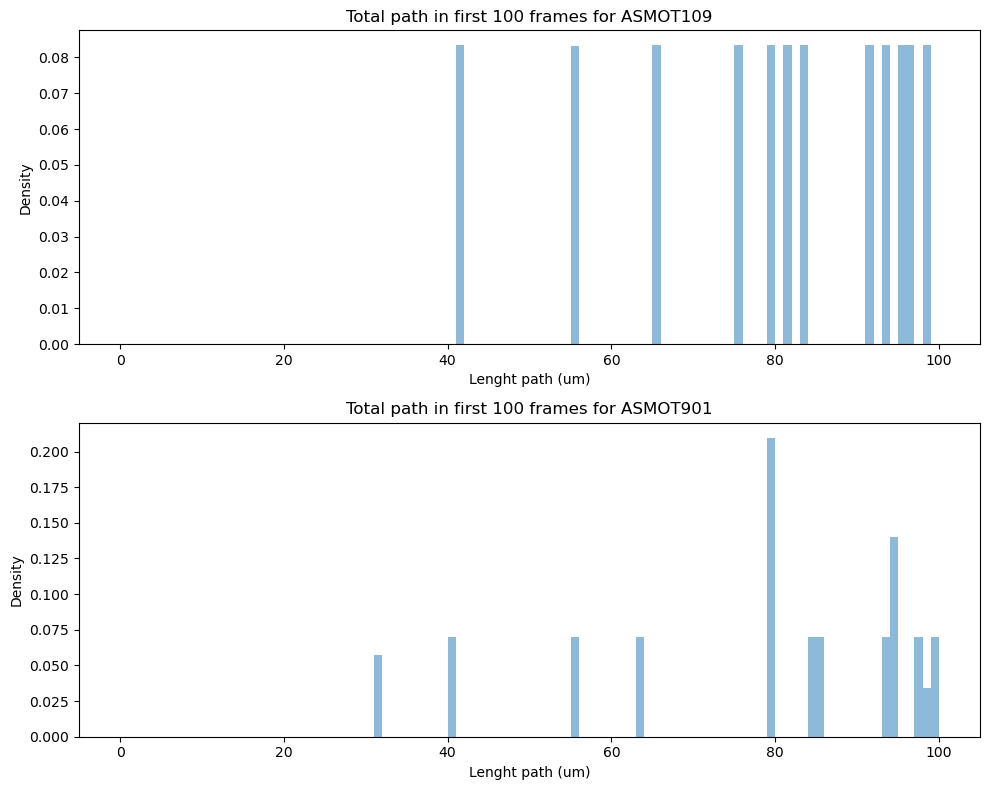

In [399]:
import matplotlib.pyplot as plt
import pandas as pd

# Grouper les données par 'experiment'
grouped = path_data.groupby('experiment')

# Calculer le nombre d'experiments pour déterminer le nombre de subplots nécessaires
n_experiments = len(grouped)

# Créer une figure et des axes pour les subplots
fig, axes = plt.subplots(nrows=n_experiments, figsize=(10, 4*n_experiments))

# Assurer que 'axes' est un array, même s'il n'y a qu'un seul subplot
if n_experiments == 1:
    axes = [axes]

for (experiment, group), ax in zip(grouped, axes):
    # Créer un histogramme pour chaque 'experiment'
    ax.hist(group['total_path_first_n'], bins=100, range=[0, 100], density=True, alpha=0.5)
    ax.set_title(f"Total path in first 100 frames for {experiment}")
    ax.set_xlabel('Lenght path (um)')
    ax.set_ylabel('Density')

# Ajuster l'espacement entre les subplots pour éviter le chevauchement
plt.tight_layout()

# Afficher la figure
plt.show()


Calcul du nombre de cellules ayant un déplacement inférieur à une valeur.

In [400]:
# Nombre de cellules avec un déplacement total inférieur à 10 sur les 20 premières frames
num_cells_low_displacement = path_data[path_data['total_path_first_n'] < 15]['particle'].nunique()

print("Nombre de cellules dont le déplacement est trop faible : " , num_cells_low_displacement)

Nombre de cellules dont le déplacement est trop faible :  0


In [401]:
# # Get the indices of rows to drop
# to_drop = find_swaps_with_return(DATA)

# print(len(to_drop), " movements to delete there while the run is too much.")

# # # Drop the rows from DATA
# DATA = DATA.drop(to_drop)
DATA.reset_index(inplace=True)

Calcul des vitesses instantanées et des trajectoires recentrées

In [402]:
# DATA = DATA[DATA['displacement [pix]'] < 5]
DATA = lib.center(traj=DATA)

print("\n"*2)
print(f"Le temps de lecture et de préparation des données pour la condition {CONDITION} est : ",
      (time.time() - INITIAL_TIME), 'min')
print("\n"*2)




Le temps de lecture et de préparation des données pour la condition Comparaison_fiji_trackpy_new_param est :  2.4559428691864014 min





In [403]:
# %% [Compute the DATAS according to some parameters]
if ROLLING_MEAN:
    DATA = lib.rolling_mean(datas=DATA, roll=3)
if PIXELISATION:
    DATA = lib.pixelisation(datas=DATA, size_pix=SIZE_PIX)
if TIME_FRAME_STUDY:
    DATA, TIME_FRAME = lib.keep_nth_image(traj=DATA, n=N_FRAME, time_frame=TIME_FRAME)

In [404]:
# #############################################################################
# %% [Calculation of total and cumulative displacement]
# #############################################################################
DATA, start_end = lib.length_displacement(traj=DATA, size_pix=SIZE_PIX)

In [405]:
# # %% [Recalcul du max displacement]
# # ###################Erasing the suspicious displacements #####################
# grouped_data = DATA.groupby('particle')
# # Obtenir la valeur maximale de 'displacement' pour chaque groupe
# max_displacements = SIZE_PIX*grouped_data['displacement [pix]'].max()
# # Sélectionner les groupes dont la valeur maximale de 'displacement' est supérieure à 10
# selected_particles = max_displacements.loc[max_displacements > 50].index.tolist()
# bool_mask = DATA['particle'].isin(selected_particles)
# DATA_HIGH_DISP = DATA[bool_mask]
# if len(DATA_HIGH_DISP) > 0:
#     lib.plot_msd(msd=tp.imsd(traj=DATA_HIGH_DISP, mpp=SIZE_PIX, fps=FPS),
#                  fps=FPS, name='MSD with HIGHT DISP (sup at 10)', color_plot=COLOR_SUP,
#                  save=True, pathway_saving=path_save_pic, alpha=ALPHA, linewidth=LINEWIDTH)
# # Erasing the spurious traectories with too high displacement
# DATA = DATA[~bool_mask]

# #############################################################################
# #############################################################################
# We now Consider having all the good particles and all good datas.
# #############################################################################
# #############################################################################

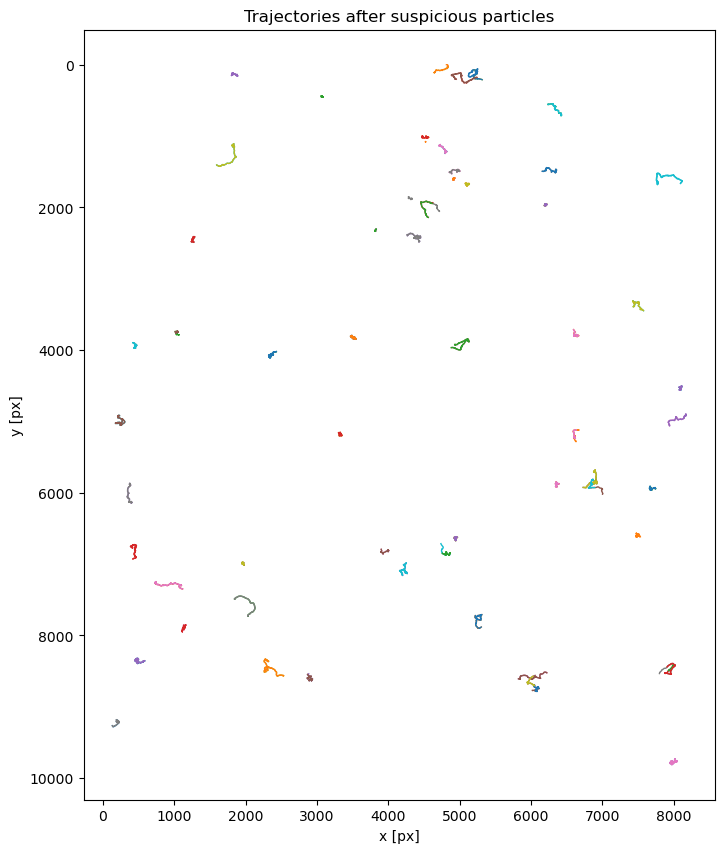

In [406]:
# %% [Plot all the trajectories]
fig, axis = plt.subplots(figsize=(10, 10))
# Assurer une échelle égale pour les axes
axis.set_aspect('equal', 'box')
plt.title('Trajectories after suspicious particles')
tp.plot_traj(DATA, label=(False))
plt.show()
fig.savefig(path_save_pic +
            'Trajectories after removing suspicious particles.jpg', format='jpg')

In [407]:
# Construire le chemin complet
image_path = os.path.join(GENERAL_PATH_PICTURES, CONDITION_simple)
image_path = image_path + '_faits'
print(image_path)

/Users/souchaud/Desktop/A_analyser/Comparaison_fiji_trackpy_faits


/var/folders/sk/m9jkmr4n1k5dqc3wj_f53p4r0000gp/T/ipykernel_25612/4152939596.py:25: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frame = imageio.imread(image_path_directory)
/var/folders/sk/m9jkmr4n1k5dqc3wj_f53p4r0000gp/T/ipykernel_25612/4152939596.py:25: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frame = imageio.imread(image_path_directory)


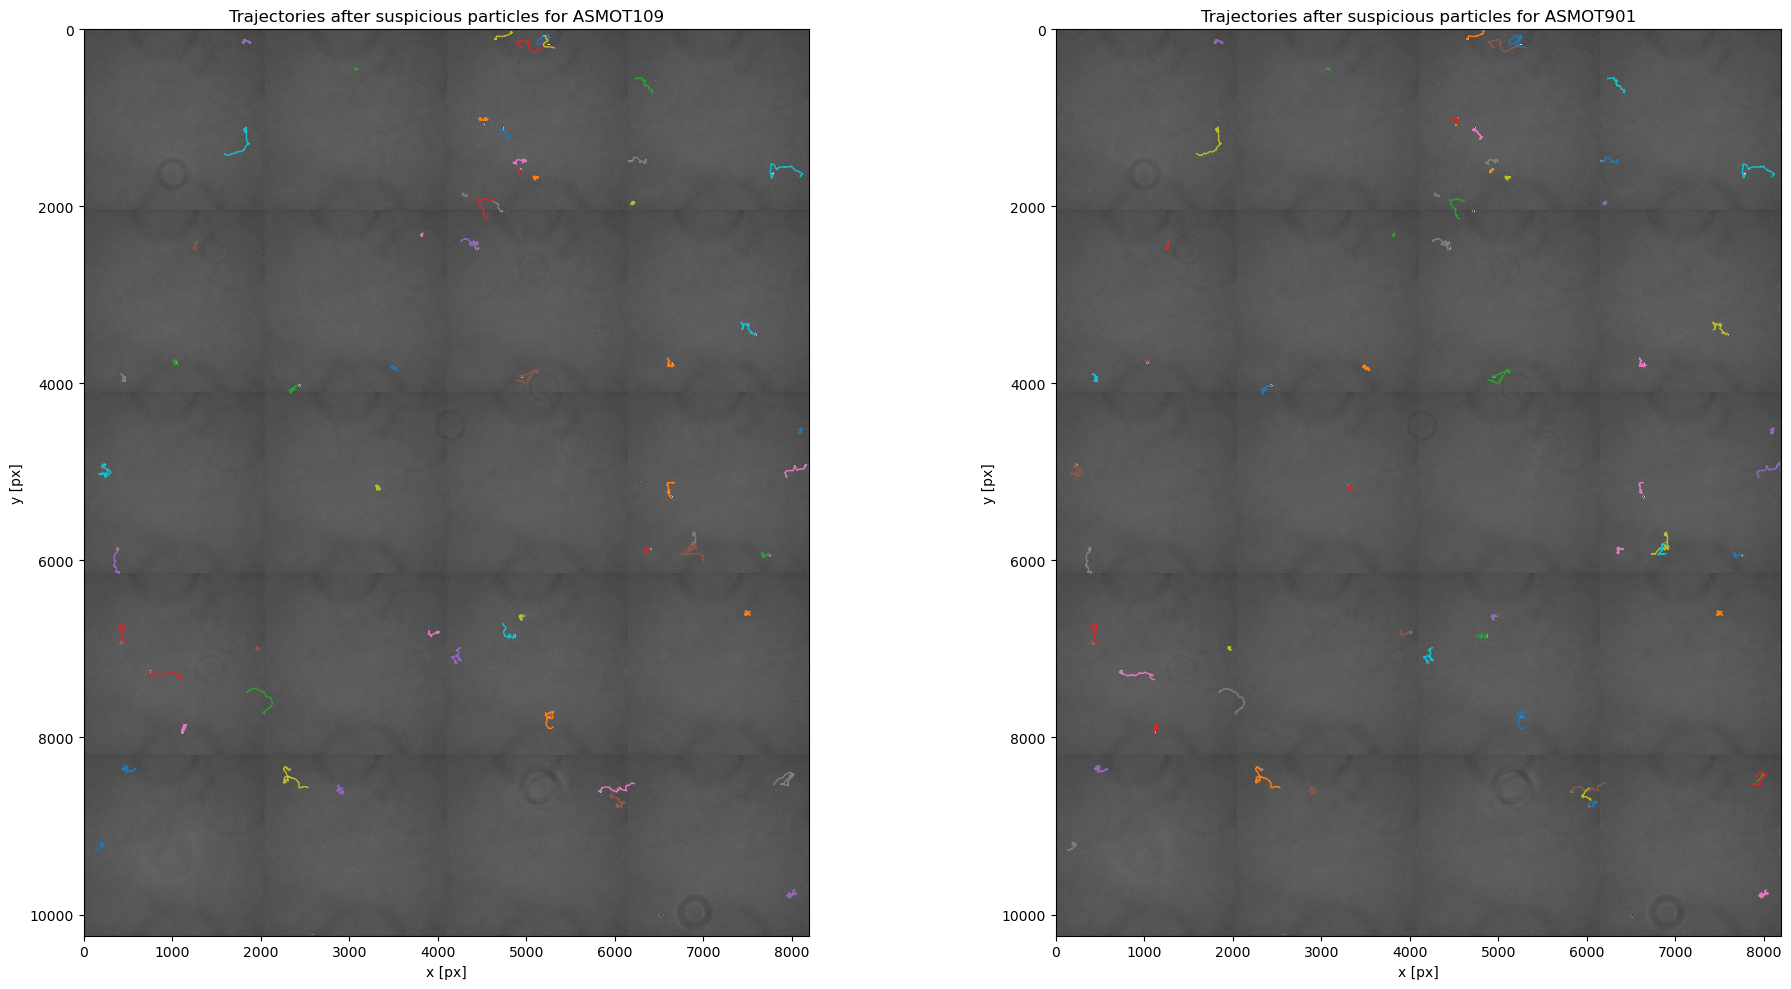

In [408]:
import trackpy as tp
import matplotlib.pyplot as plt

# Supposons que DATA est votre DataFrame
plot_exp = DATA.groupby('experiment')

# Déterminer le nombre de sous-graphiques basé sur le nombre d'expériences
num_experiments = len(plot_exp)
num_cols = 2  # Par exemple, vous pouvez définir 2 colonnes pour vos sous-graphiques
num_rows = (num_experiments + num_cols - 1) // num_cols  # Calculer le nombre de lignes nécessaire

# Créer la figure et les axes pour les sous-graphiques
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 10))  # Ajustez la taille selon vos besoins
axes = axes.flatten()  # Aplatir le tableau d'axes pour une itération facile

for ax, (exp_name, exp_data) in zip(axes, plot_exp):
    exp_directories = []
    for dirpath, dirnames, filenames in os.walk(image_path):
        for dirname in dirnames:
            if exp_name in dirname:
                full_path = os.path.join(dirpath, dirname)
                exp_directories.append(full_path)
    if exp_directories:
        image_path_directory = f'{exp_directories[0]}/mosaic/mosaic_total_0.tif'
        frame = imageio.imread(image_path_directory)
        ax.set_aspect('equal', 'box')
        ax.set_title(f'Trajectories after suspicious particles for {exp_name}')
        tp.plot_traj(exp_data, superimpose=frame, label=False, ax=ax)
    else:
        print(f"No directory found for {exp_name}")
        ax.axis('off')
# Ajuster la mise en page pour éviter le chevauchement
plt.tight_layout()
plt.show()
fig.savefig(path_save_pic + 'trajectories_on_frame_all_experiment.pdf', format='pdf')


In [409]:
series_y = DATA.groupby('experiment')['y'].max().div(2048).apply(math.ceil).astype(int)
series_x = DATA.groupby('experiment')['x'].max().div(2048).apply(math.ceil).astype(int)
# Multiplication élément par élément entre les deux séries
result = series_y * series_x

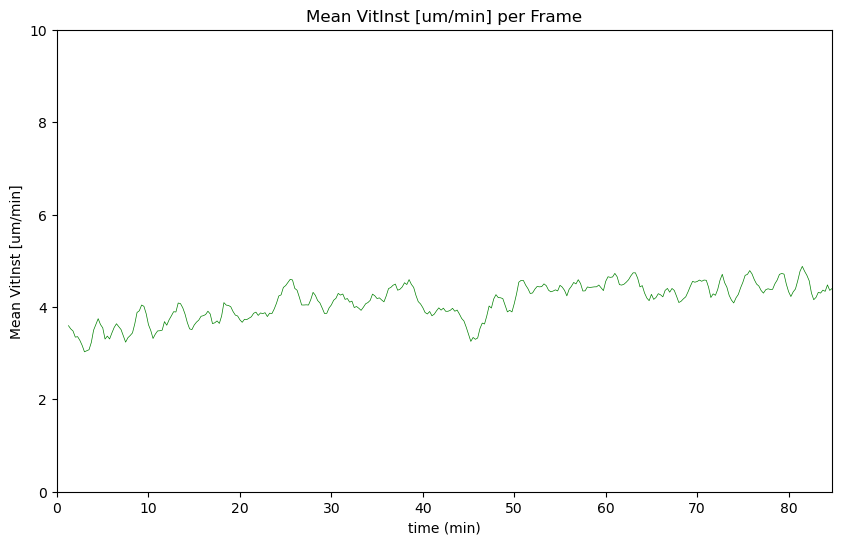

In [410]:
# %% [Mean speed]
# Grouper les données par 'frame' et calculer la moyenne de 'VitInst [um/min]'
mean_VitInst_per_frame = DATA.groupby('time (min)')['VitInst [um/min]'].mean()
mean_VitInst_per_frame.index = mean_VitInst_per_frame.index

mean_VitInst_per_frame = mean_VitInst_per_frame.rolling(5).mean().dropna()

lib.plot_datas(x_values=mean_VitInst_per_frame.index,
               y_values=mean_VitInst_per_frame.values,
               title='Mean VitInst [um/min] per Frame',
               x_label='time (min)', y_label='Mean VitInst [um/min]',
               x_lim=[0, max(mean_VitInst_per_frame.index)], y_lim=[0, 10], save=True,
               path_save_pic=path_save_pic, img_type="jpg")


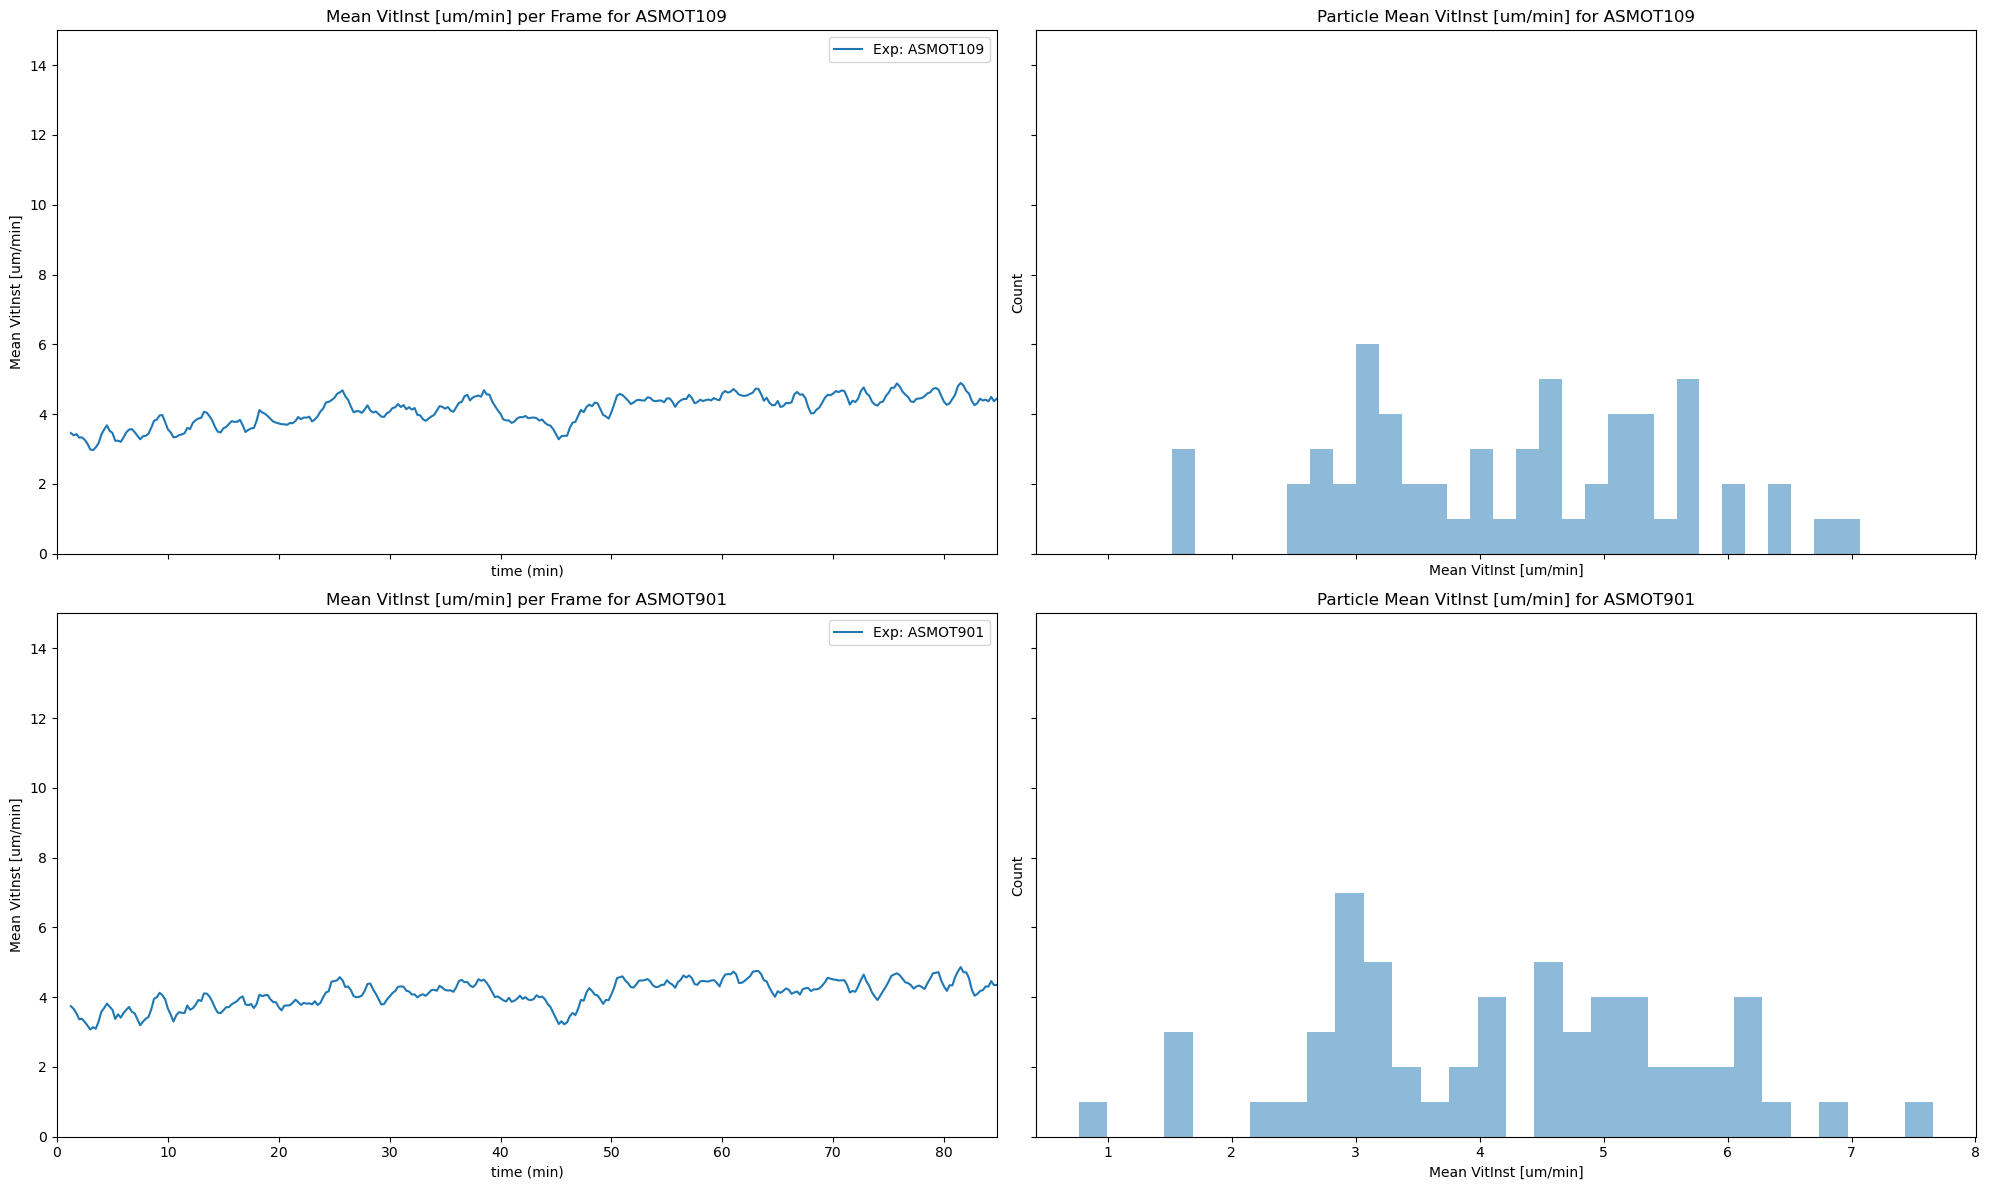

In [412]:
import matplotlib.pyplot as plt
import pandas as pd

# Supposons que DATA est votre DataFrame
experiments = DATA['experiment'].unique()
n_experiments = len(experiments)

# Créer une figure avec deux colonnes de subplots pour chaque expérience
# La première colonne pour la vitesse instantanée moyenne par frame
# La deuxième colonne pour l'histogramme de la vitesse moyenne des particules
fig, axes = plt.subplots(n_experiments, 2, figsize=(20, 6*n_experiments), sharex='col', sharey='row')

# S'assurer que axes est toujours un array 2D pour faciliter l'itération
if n_experiments == 1:
    axes = np.expand_dims(axes, 0)

for i, exp in enumerate(experiments):
    # Filtrer les données pour l'expérience courante
    data_exp = DATA[DATA['experiment'] == exp]
    
    # Premier subplot : vitesse instantanée moyenne par frame
    mean_VitInst_per_frame_i = data_exp.groupby('time (min)')['VitInst [um/min]'].mean()
    mean_VitInst_per_frame_i.index = mean_VitInst_per_frame_i.index
    mean_VitInst_per_frame_smoothed_i = mean_VitInst_per_frame_i.rolling(5).mean().dropna()
    axes[i, 0].plot(mean_VitInst_per_frame_smoothed_i.index, mean_VitInst_per_frame_smoothed_i.values, label=f'Exp: {exp}')
    axes[i, 0].set_title(f'Mean VitInst [um/min] per Frame for {exp}')
    axes[i, 0].set_xlabel('time (min)')
    axes[i, 0].set_ylabel('Mean VitInst [um/min]')
    axes[i, 0].set_xlim([0, max(mean_VitInst_per_frame_i.index)])  # Ajustez selon vos données
    axes[i, 0].set_ylim([0, 15])   # Ajustez selon vos données
    axes[i, 0].legend()

    # Deuxième subplot : histogramme de la vitesse moyenne des particules pour l'expérience
    mean_VitInst_per_particle_i = data_exp.groupby('particle')['VitInst [um/min]'].mean()
    axes[i, 1].hist(mean_VitInst_per_particle_i, bins=30, alpha=0.5)
    axes[i, 1].set_title(f'Particle Mean VitInst [um/min] for {exp}')
    axes[i, 1].set_xlabel('Mean VitInst [um/min]')
    axes[i, 1].set_ylabel('Count')

# Ajuster automatiquement l'espacement entre les subplots pour éviter le chevauchement
plt.tight_layout()

# Afficher la figure
plt.show()

# Si vous souhaitez sauvegarder la figure entière
# plt.savefig(f"{path_save_pic}/combined_mean_vitinst_per_experiment.jpg", format="jpg")


/var/folders/sk/m9jkmr4n1k5dqc3wj_f53p4r0000gp/T/ipykernel_25612/3141381612.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = plt.cm.get_cmap('tab10', nombre_experiences)  # 'tab10' est une palette de 10 couleurs


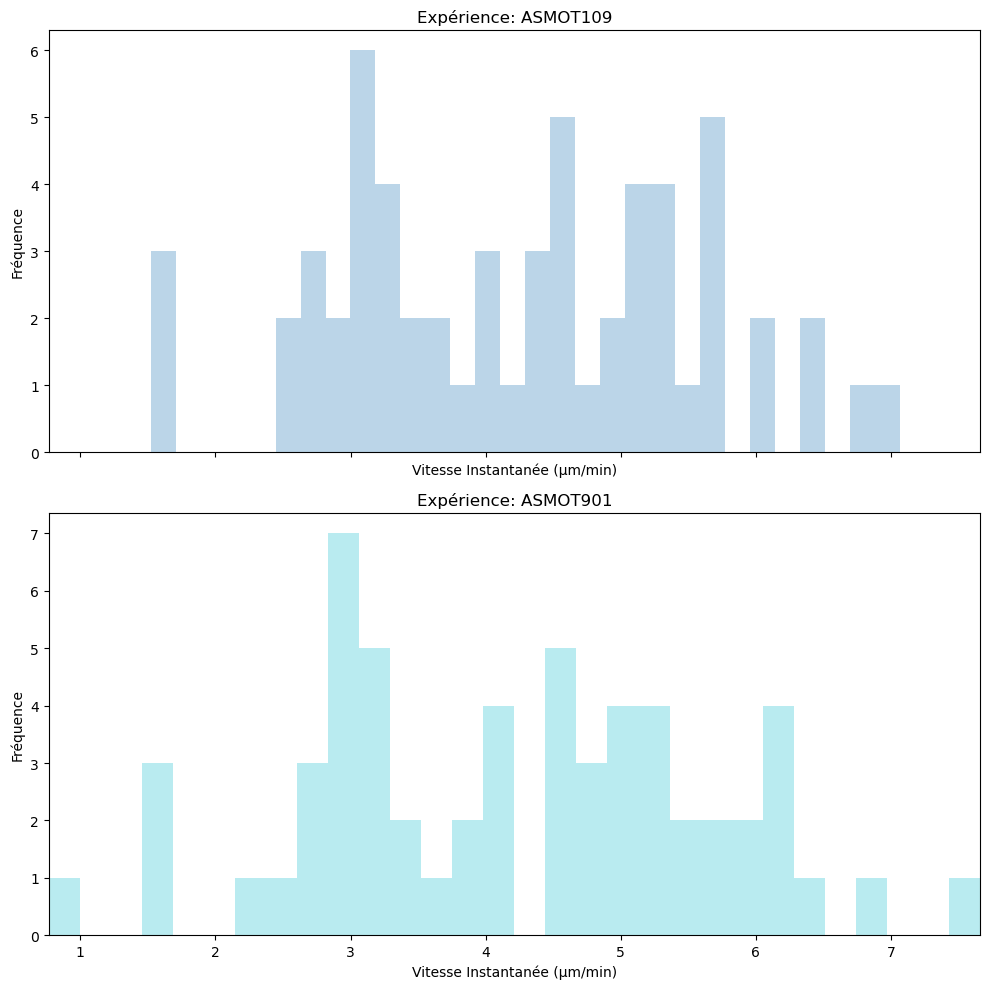

In [413]:
import matplotlib.pyplot as plt
import numpy as np

# Supposons que DATA est un DataFrame Pandas avec vos données
experiences_uniques = DATA['experiment'].unique()
nombre_experiences = len(experiences_uniques)

# Créer une grille de subplots avec un nombre approprié de lignes
fig, axs = plt.subplots(nombre_experiences, 1, figsize=(10, 5 * nombre_experiences), sharex=True)

# Générer une palette de couleurs
palette = plt.cm.get_cmap('tab10', nombre_experiences)  # 'tab10' est une palette de 10 couleurs

# Définir les limites de l'axe des x basées sur les données globales
x_min = DATA.groupby('particle')['VitInst [um/min]'].mean().min()
x_max = DATA.groupby('particle')['VitInst [um/min]'].mean().max()

# Assurez-vous que axs est un array, même s'il n'y a qu'un seul subplot
if nombre_experiences == 1:
    axs = [axs]

# Remplir chaque subplot
for idx, exp in enumerate(experiences_uniques):
    # Calculer la moyenne de la vitesse instantanée pour chaque particule
    moyennes_vitesses = DATA[DATA['experiment'] == exp].groupby('particle')['VitInst [um/min]'].mean()
    
    # Créer un histogramme sur le subplot correspondant avec une couleur unique
    axs[idx].hist(moyennes_vitesses, bins=30, alpha=0.3, color=palette(idx))
    axs[idx].set_title(f'Expérience: {exp}')
    axs[idx].set_xlabel('Vitesse Instantanée (µm/min)')
    axs[idx].set_ylabel('Fréquence')
    axs[idx].set_xlim([x_min, x_max])  # Appliquer la même échelle des x à tous les subplots

# Ajuster l'espace entre les subplots pour éviter le chevauchement
plt.tight_layout()
plt.show()


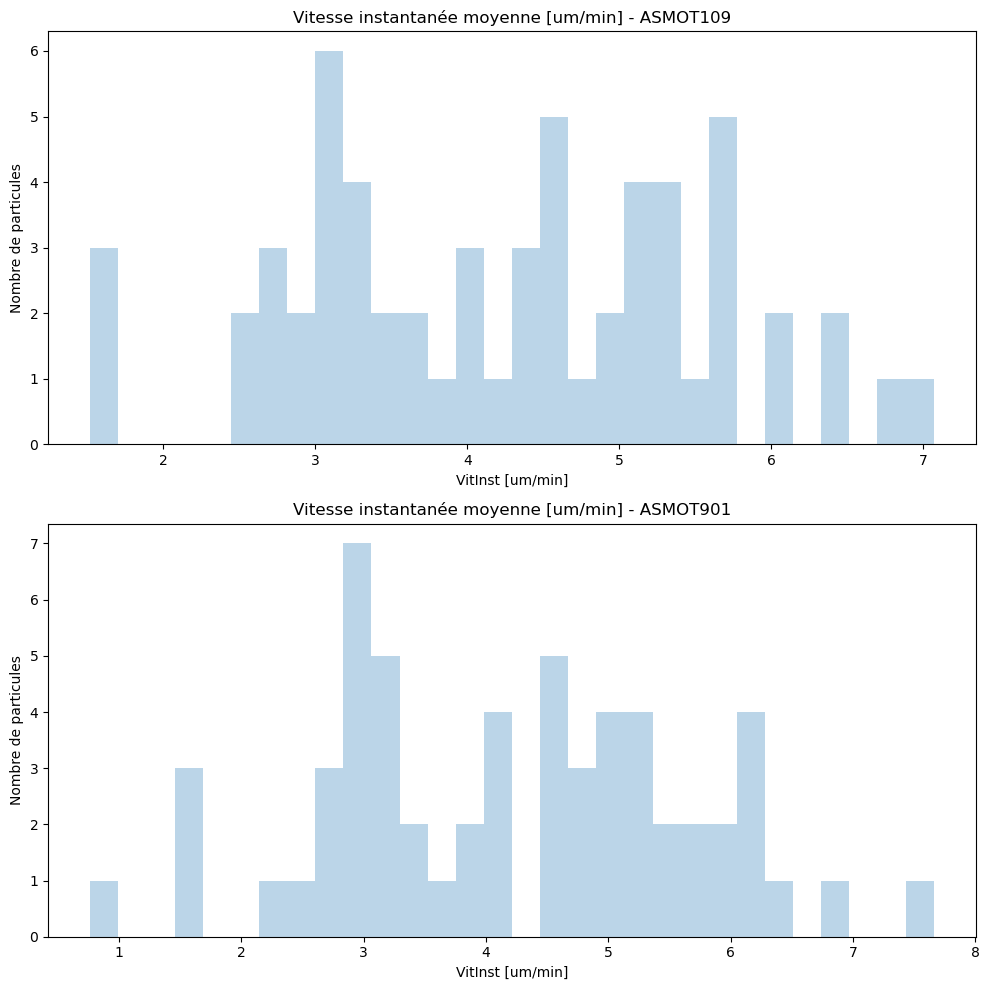

In [414]:
import matplotlib.pyplot as plt

# Obtenir la liste unique des expériences
experiments = DATA['experiment'].unique()
n_experiments = len(experiments)

# Créer une figure et un ensemble de subplots
# Ajustez nrows et ncols selon le nombre d'experiences que vous avez
fig, axes = plt.subplots(nrows=n_experiments, ncols=1, figsize=(10, 5*n_experiments))

# S'assurer que 'axes' est un array pour faciliter l'itération, même s'il n'y a qu'une seule expérience
if n_experiments == 1:
    axes = [axes]

for ax, exp in zip(axes, experiments):
    # Sélectionner les données pour l'expérience courante
    data_exp = DATA[DATA['experiment'] == exp]
    
    # Calculer la vitesse instantanée moyenne pour chaque particule
    mean_vitinst_per_particle = data_exp.groupby('particle')['VitInst [um/min]'].mean()
    
    # Tracer l'histogramme sur le subplot correspondant
    ax.hist(mean_vitinst_per_particle, bins=30, alpha=0.3)
    ax.set_title(f'Vitesse instantanée moyenne [um/min] - {exp}')
    ax.set_xlabel('VitInst [um/min]')
    ax.set_ylabel('Nombre de particules')

# Ajuster l'espacement entre les subplots pour éviter le chevauchement
plt.tight_layout()

# Afficher la figure
plt.show()


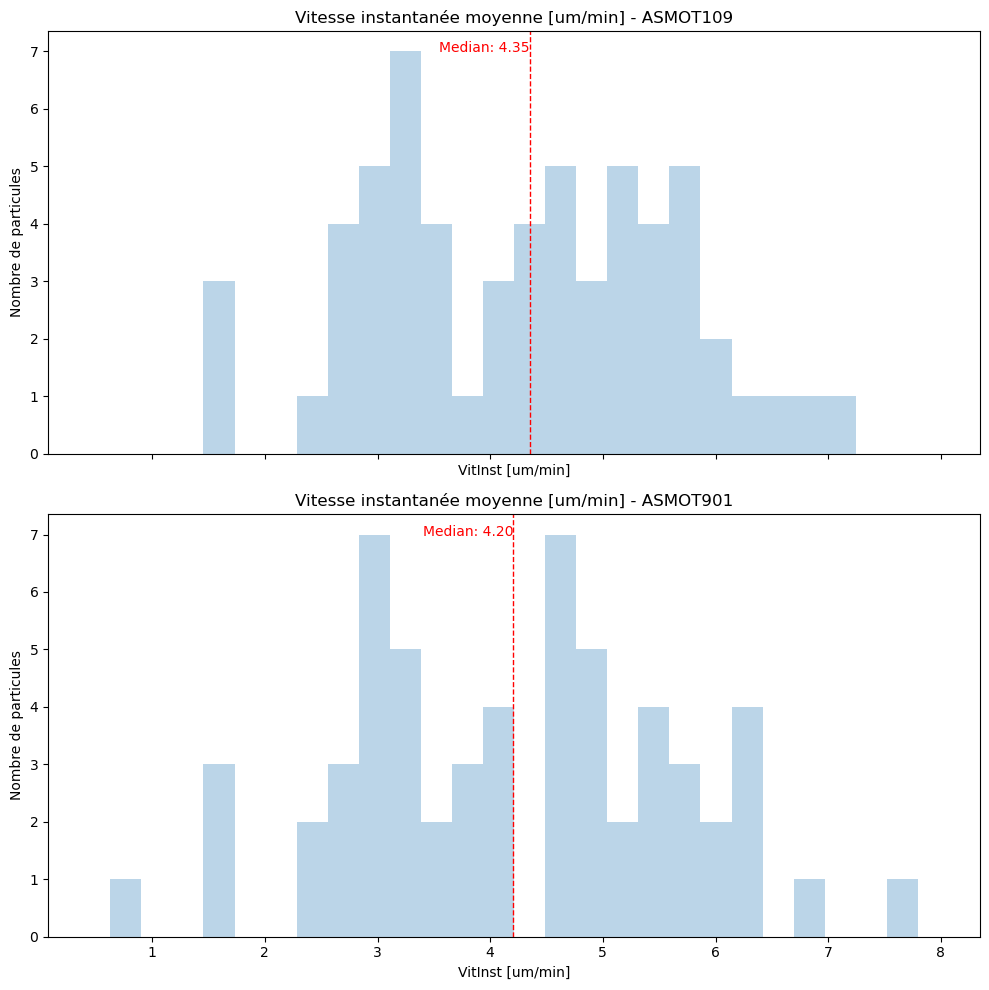

In [415]:
import matplotlib.pyplot as plt

# Calculer les limites globales pour la vitesse instantanée moyenne
all_mean_vitinst = DATA.groupby(['experiment', 'particle'])['VitInst [um/min]'].mean()
global_min, global_max = all_mean_vitinst.min(), all_mean_vitinst.max()

# Ajuster légèrement les limites pour une meilleure visualisation
global_min, global_max = global_min - (global_max - global_min) * 0.1, global_max + (global_max - global_min) * 0.1

# Obtenir la liste unique des expériences
experiments = DATA['experiment'].unique()
n_experiments = len(experiments)

# Créer une figure et un ensemble de subplots
fig, axes = plt.subplots(nrows=n_experiments, ncols=1, figsize=(10, 5*n_experiments), sharex=True, sharey=True)

# S'assurer que 'axes' est un array pour faciliter l'itération, même s'il n'y a qu'une seule expérience
if n_experiments == 1:
    axes = [axes]

for ax, exp in zip(axes, experiments):
    # Sélectionner les données pour l'expérience courante
    data_exp = DATA[DATA['experiment'] == exp]
    
    # Calculer la vitesse instantanée moyenne pour chaque particule
    mean_vitinst_per_particle = data_exp.groupby('particle')['VitInst [um/min]'].mean()
    
    # Tracer l'histogramme sur le subplot correspondant
    ax.hist(mean_vitinst_per_particle, bins=30, alpha=0.3, range=(global_min, global_max))
    ax.set_title(f'Vitesse instantanée moyenne [um/min] - {exp}')
    ax.set_xlabel('VitInst [um/min]')
    ax.set_ylabel('Nombre de particules')
    
    # Calculer et tracer la médiane en rouge
    median_value = mean_vitinst_per_particle.median()
    ax.axvline(median_value, color='red', linestyle='dashed', linewidth=1)
    ax.text(median_value, ax.get_ylim()[1]*0.95, f'Median: {median_value:.2f}', color='red', ha='right')

    # Appliquer les mêmes limites d'axes à tous les subplots
    ax.set_xlim(global_min, global_max)

# Ajuster l'espacement entre les subplots pour éviter le chevauchement
plt.tight_layout()

# Afficher la figure
plt.show()


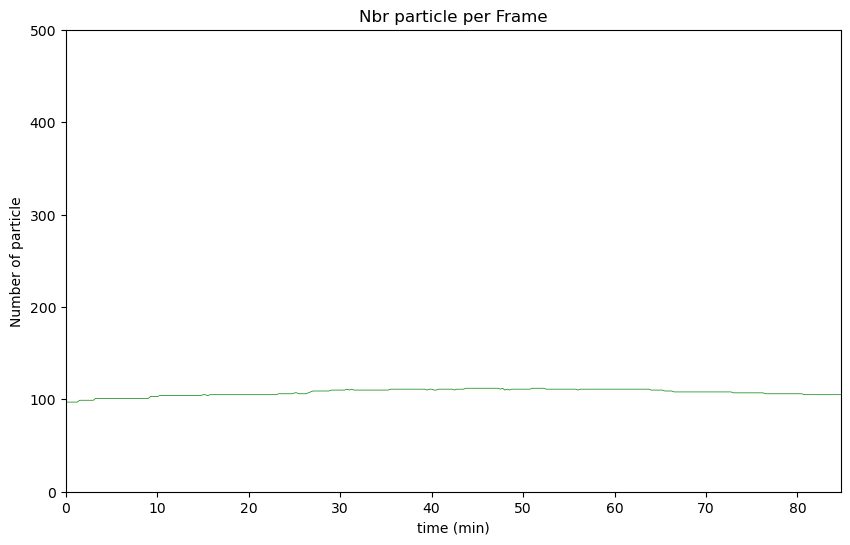

In [416]:
# %% [Number of particle on each frame]

# Grouper les données par 'frame' et calculer la moyenne de 'VitInst [um/min]'
nbr_part_per_frame = DATA.groupby('time (min)')['particle'].nunique()

lib.plot_datas(x_values=nbr_part_per_frame.index, y_values=nbr_part_per_frame.values,
               title='Nbr particle per Frame',
               x_label='time (min)', y_label='Number of particle',
               x_lim=[0, max(nbr_part_per_frame.index)], y_lim=[0, 500], save=True,
               path_save_pic=path_save_pic, img_type="jpg")

In [417]:
import pandas as pd
import numpy as np

# Supposons que df est votre DataFrame contenant les résultats du tracking
# df devrait avoir des colonnes 'particle', 'frame', 'x', et 'y'
df = DATA
# Fonction pour calculer le vecteur de déplacement
def displacement_vectors(df):
    df['dx'] = df.groupby('particle')['x'].diff()
    df['dy'] = df.groupby('particle')['y'].diff()
    return df.dropna()

# Normaliser les vecteurs de déplacement
def normalize_vectors(df):
    df = df.copy()
    magnitude = np.sqrt(df['dx']**2 + df['dy']**2)
    df.loc[:, 'dx_norm'] = df['dx'] / magnitude
    df.loc[:, 'dy_norm'] = df['dy'] / magnitude
    return df

# Calculer l'angle des vecteurs
# Arctan2 permet de calculer l'angle en radians entre la partie positive de l'axe des abscisses d'un plan et le point (x,y)
# Angle positif dans le sens trigo et négativ dans le sens inverse trigo
def calculate_angles(df):
    df = df.copy()
    df.loc[:, 'angle'] = np.arctan2(df['dy_norm'], df['dx_norm'])
    return df

# Calculer l'autocorrélation directionnelle
def direction_autocorrelation(df, max_lag):
    results = []
    for particle in df['particle'].unique():
        particle_df = df[df['particle'] == particle].copy()
        for lag in range(1, max_lag + 1):
            particle_df['angle_lag'] = particle_df['angle'].shift(-lag)
            cos_diff = np.cos(particle_df['angle'] - particle_df['angle_lag'])
            autocorr = cos_diff.mean()
            results.append({'particle': particle, 'lag': lag, 'autocorrelation': autocorr})
    return pd.DataFrame(results).dropna()

# Appliquer les fonctions
df = displacement_vectors(df)
df = normalize_vectors(df)
df = calculate_angles(df)
max_lag = 10  # Ajustez en fonction de la longueur de vos trajectoires
autocorr_df = direction_autocorrelation(df, max_lag)

In [418]:
IMSD = tp.imsd(traj=DATA,
               mpp=SIZE_PIX, fps=FPS,
               max_lagtime=200, statistic='msd',
               pos_columns=None)
IMSD

,0,1,2,3,4,5,6,7,8,9,...,109,110,111,112,113,114,115,116,117,118
lag time [s],,,,,,,,,,,,,,,,,,,,,
15.0,2.651233,1.012027,0.978906,0.769914,1.871577,2.275506,0.919537,2.777149,0.815321,2.367022,...,1.756731,3.395452,0.048549,3.186191,4.760989,3.205144,1.488259,1.259737,0.721497,3.405369
30.0,9.416545,3.108616,3.103412,2.449472,6.183931,7.471362,2.966862,6.892980,2.783707,8.094282,...,5.561339,10.488510,0.065194,10.266972,15.381983,10.864903,5.314147,3.963842,2.333160,11.193854
45.0,19.636617,5.879409,5.992126,4.826538,12.675223,14.842907,5.844431,13.749732,5.651039,16.685485,...,10.774850,19.565508,0.087356,20.035709,30.359825,22.260601,11.133354,7.894567,4.487582,22.519760
60.0,33.090266,9.243856,9.526695,7.700065,21.190121,24.023246,9.464411,22.368729,9.232035,27.714799,...,17.031188,29.583003,0.102469,32.026802,49.071761,36.850840,18.738147,12.774996,7.043267,36.828360
75.0,49.390171,12.999054,13.610621,11.015921,31.273814,34.955819,13.630607,32.545577,13.338591,40.817734,...,24.194267,40.958292,0.116974,45.821160,71.041529,54.006466,27.983927,18.472438,9.879898,53.180493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2940.0,NaN,558.324071,1718.759156,558.431471,17660.835617,8529.061788,2784.810106,NaN,361.322338,2659.660391,...,11831.079162,NaN,2.374982,14900.938086,NaN,28421.895560,2027.358152,NaN,NaN,NaN
2955.0,NaN,563.944984,1726.956680,562.540340,17827.732119,8579.094144,2806.613161,NaN,362.628017,2665.325448,...,11958.624864,NaN,2.396560,14951.953177,NaN,28486.811822,2025.467653,NaN,NaN,NaN
2970.0,NaN,569.738344,1734.278660,566.179711,17993.314789,8629.683228,2829.027330,NaN,363.759817,2672.511277,...,12088.104426,NaN,2.427005,15003.023868,NaN,28524.541999,2031.309258,NaN,NaN,NaN


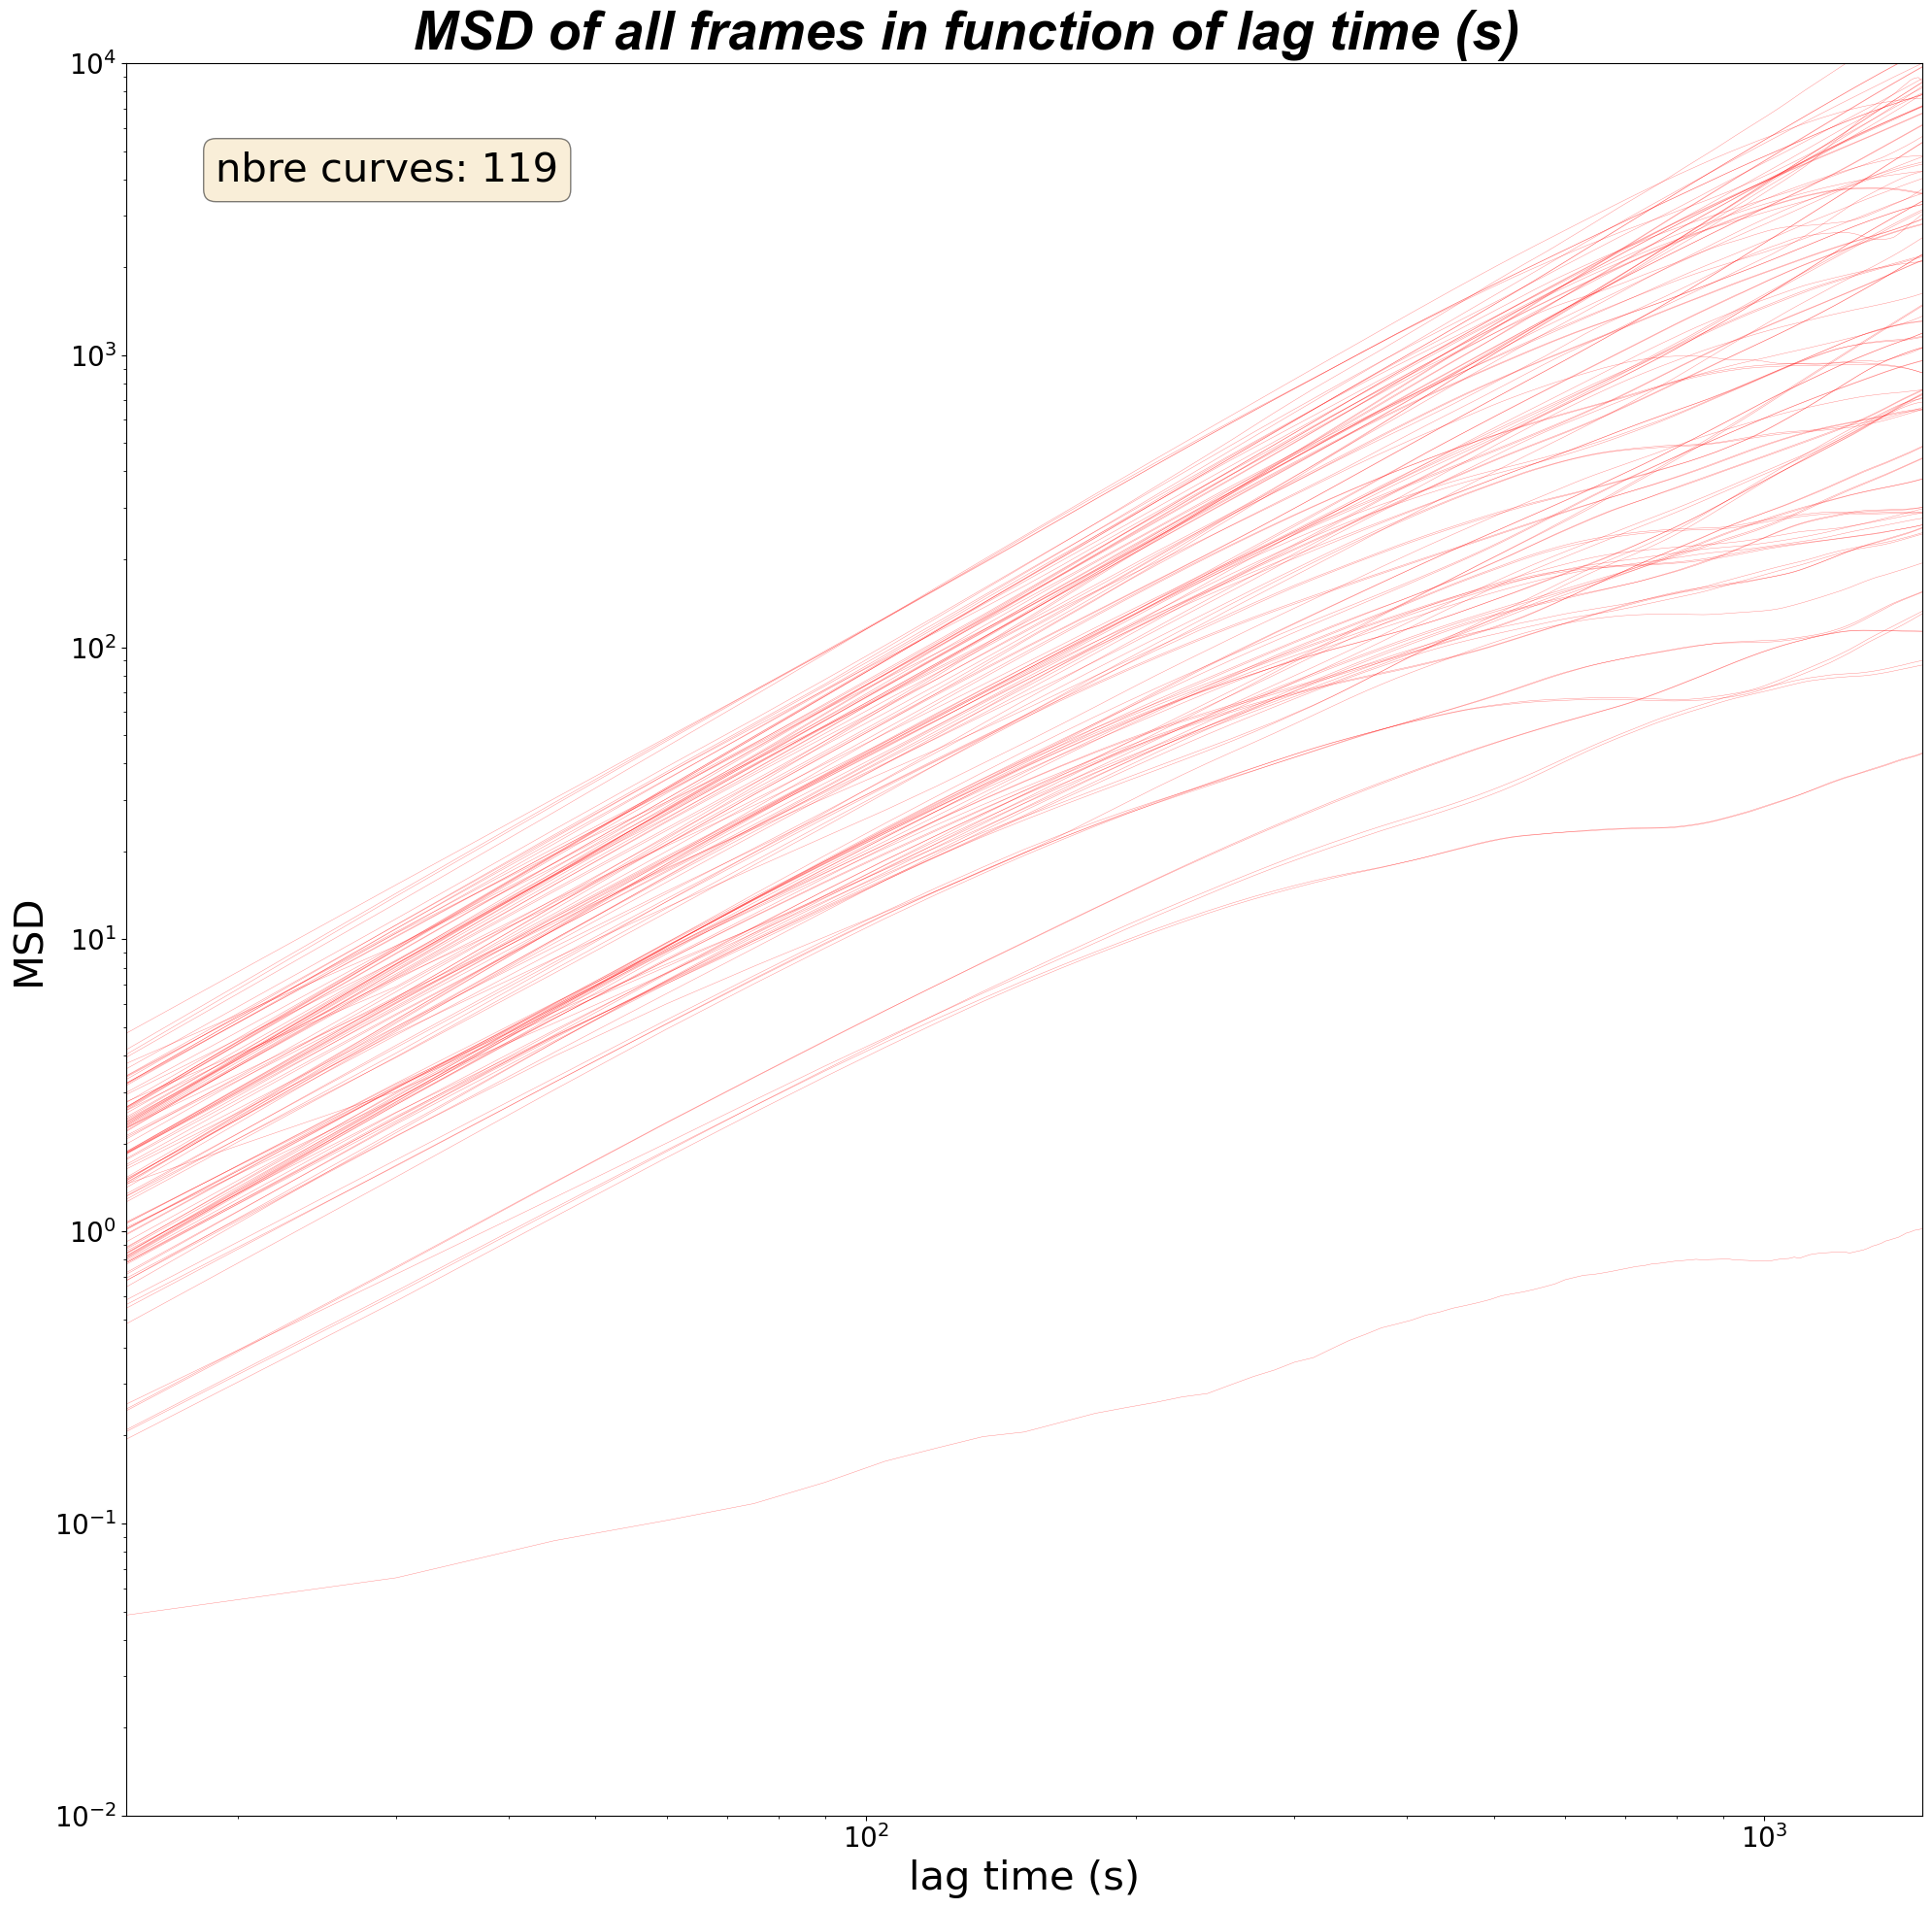

In [419]:
lib.plot_msd(IMSD, fps=FPS, name="MSD of all frames in function of lag time (s)",
             color_plot = 'red', save=False, pathway_saving=None,
             alpha=0.5, linewidth=0.3, img_type='jpg')

# negative slope 0


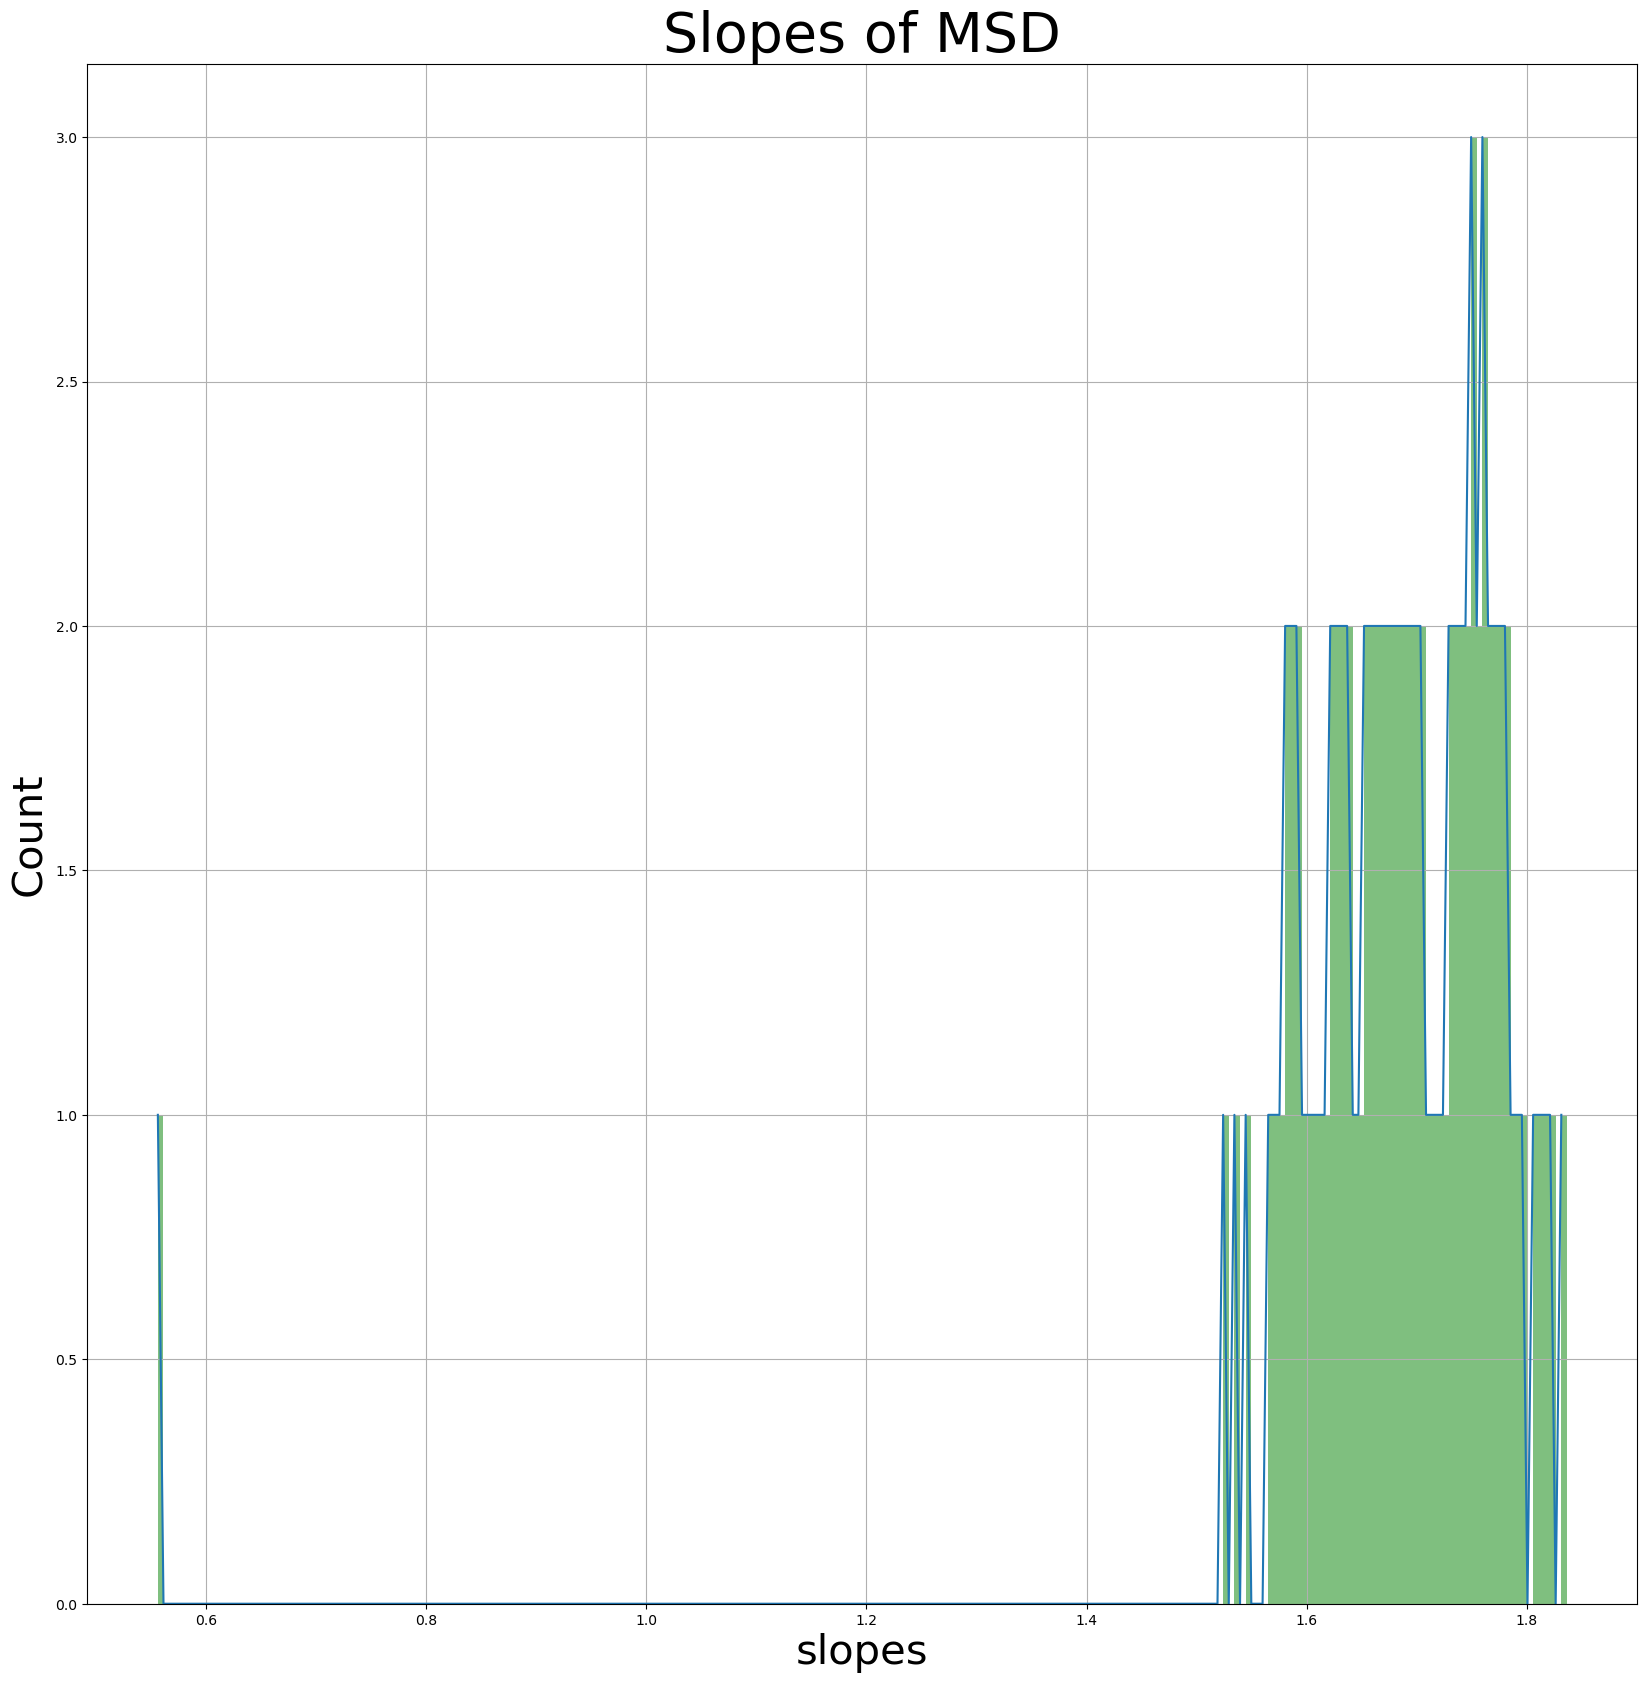

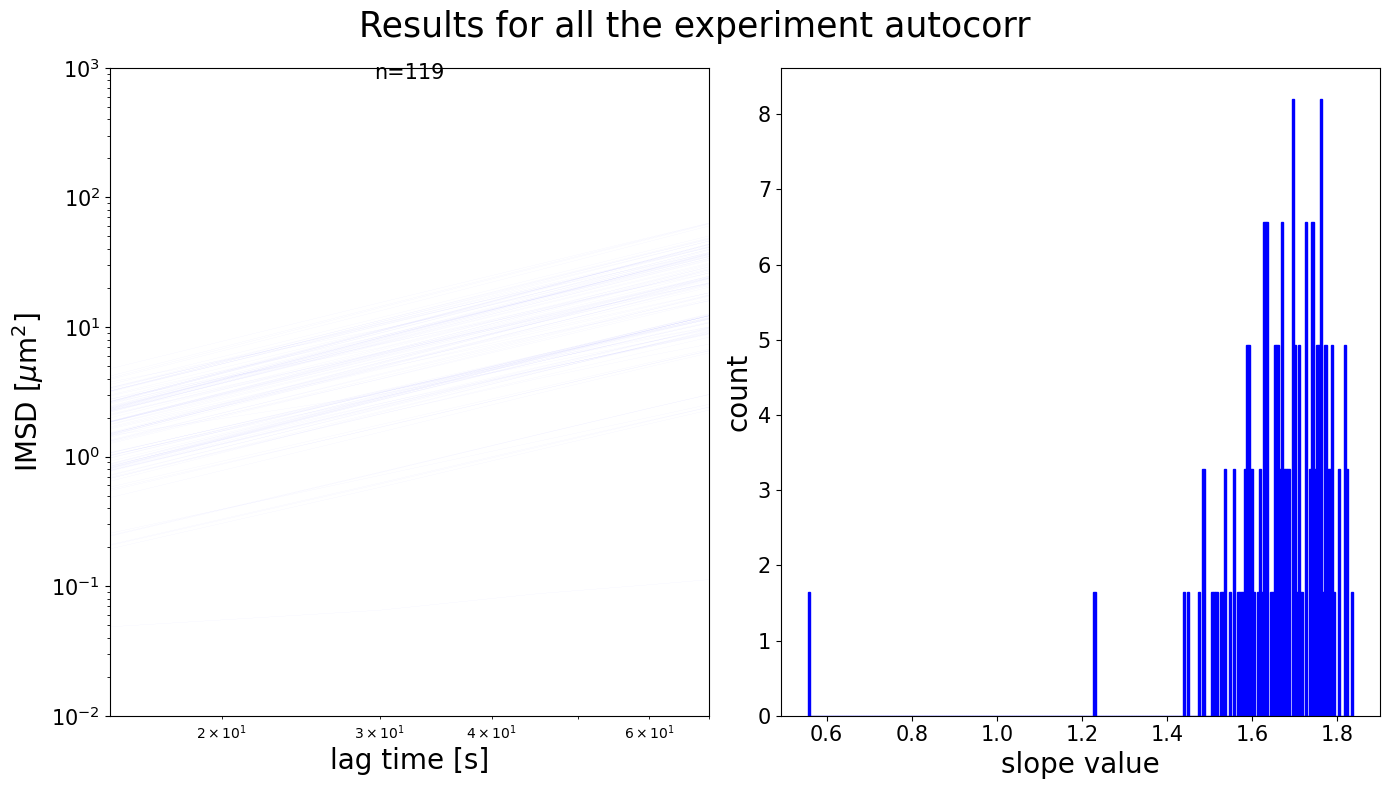

In [420]:
# %% [traj clustering with fit and defining a cutoff]
LAG_TIME_FIT = 5
# Compute et plot the director factor of the imsd
importlib.reload(lib)

COEF_INF, COEF_SUP, PART_COEF_INF, PART_COEF_SUP, CUTOFF =\
    lib.traj_clustering_with_fit_cutoff(DATA, imsd=IMSD, hist=True,
                                        lag_time_fit=LAG_TIME_FIT,
                                        micronperpixel=SIZE_PIX,
                                        fps=FPS, binsize=250,
                                        peak_height=50, peak_width=1,
                                        save=True, pathway_fig=path_save_pic,
                                        name='all the experiment autocorr', img_type="jpg",
                                        plot=True, color_sup_inf=color_sup_inf,
                                        cutoff_default=0.5
                                        )

# # DATA_INF, DATA_SUP, IMSD_INF, IMSD_SUP,
# DATA_INF = DATA[DATA['particle'].isin(PART_COEF_INF)]
# DATA_SUP = DATA[DATA['particle'].isin(PART_COEF_SUP)]
# IMSD_INF = IMSD.loc[:, IMSD.columns.isin(PART_COEF_INF)]
# IMSD_SUP = IMSD.loc[:, IMSD.columns.isin(PART_COEF_SUP)]

In [421]:
# for numero_particule in df_negative['particle'].unique():
#     print(numero_particule)
#     print("Etude de la particule : ", numero_particule, ' dans la manip', DATA[DATA['particle']==numero_particule]['experiment'].iloc[0])
#     lib.create_cropped_tracking_gif(datas=DATA, target_particle = numero_particule,
#                                     condition = CONDITION_simple,
#                                     dot_size= 7,
#                                     crop_size=100, 
#                                     gif=False,
#                                     pathway_saving=None,
                                    # pathway_initial='/Volumes/Labo_Alex_Mac/A_analyser/')

In [422]:
# Assurez-vous que sums_df est un DataFrame Pandas
sums_df = pd.DataFrame(columns=['experiment', 'particle', 'displacement_sum'])

rows = []

for exp in DATA['experiment'].unique():
    exp_data = DATA[DATA['experiment'] == exp]
    for particle_id, part in exp_data.groupby('particle'):
        displacement_sum = part['displacement [pix]'].head(200).sum()
        new_row = {'experiment': exp, 'particle': particle_id, 'displacement_sum': displacement_sum}
        rows.append(new_row)

# Création d'un nouveau DataFrame à partir de la liste de dictionnaires
sums_df = pd.DataFrame(rows)


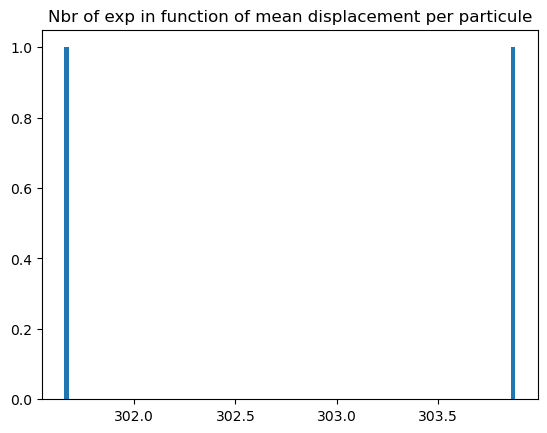

In [423]:
mean_sum = []
for _, exp in sums_df.groupby('experiment'):
    mean_sum.append(exp['displacement_sum'].mean())

plt.hist(mean_sum, bins = 100)
plt.title("Nbr of exp in function of mean displacement per particule")
plt.savefig(path_save_pic + f"Nbr of exp in function of mean displacement per particule {CONDITION_simple}.png", format='png') 
plt.show()

In [424]:
# Y'a t'il l'air d'enregistrer? 
# size en fonction ? 
# faire des manip en x10
# calculer un pseudo packing fraction : nombre de cellule par unité d'air. Ensuite, on essaye de voir la size des cells. 
# Cela dit, c'est vraiment le nombre de cellules par unité d'aire qui m'interesse

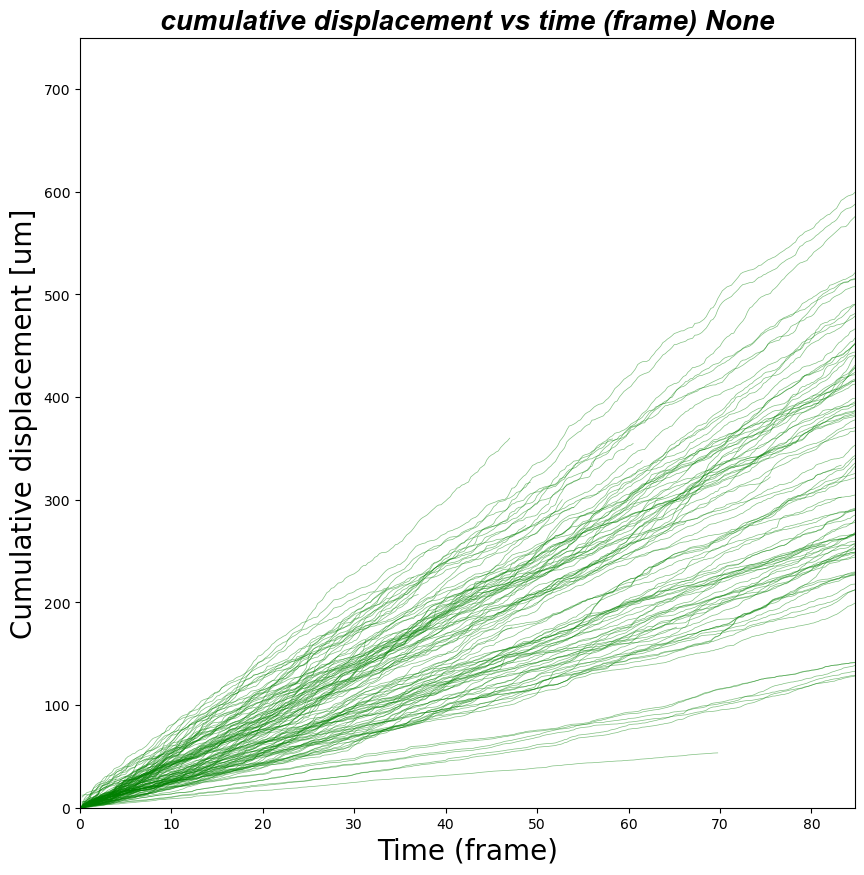

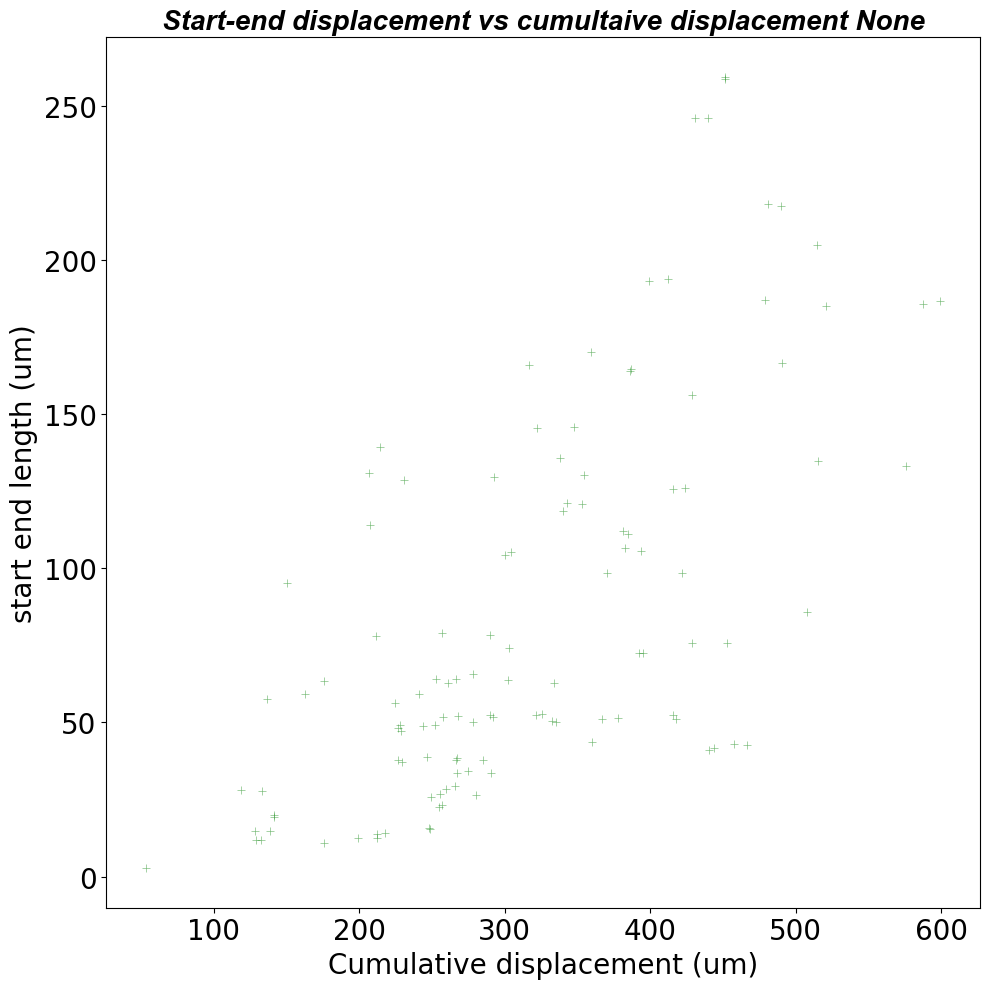

In [425]:
importlib.reload(lib)
lib.plot_displacement(DATA, start_end=start_end, alpha = 0.5, linewidth=0.5, ylim=[0, 750], xlim=[0, max(DATA['time (min)'])])
plt.show()

(0.0, 400.0)

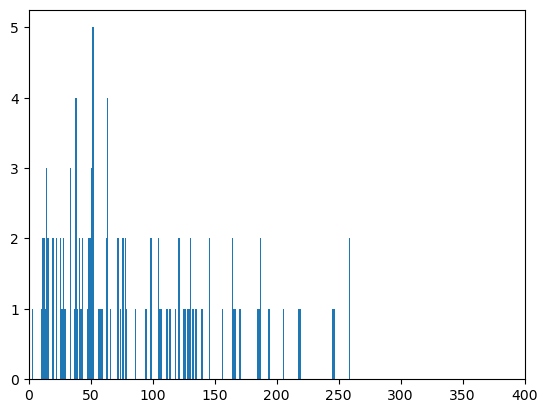

In [426]:
plt.hist(start_end, bins=250)
plt.xlim([0,400])

In [427]:
cumulative = DATA.groupby('particle')['cumulative displacement [um]'].last()
cumulative_filtered = cumulative[cumulative > 200]
filtered_DATA = DATA[DATA['particle'].isin(cumulative_filtered.index)]
for i in filtered_DATA['particle'].unique():
    print(filtered_DATA[filtered_DATA['particle']==i].iloc[0])

index                                                                           0
y                                                                       95.964718
x                                                                     5239.625082
mass                                                                 29101.271983
size                                                                    15.492201
ecc                                                                      0.162321
signal                                                                  31.462237
raw_mass                                                                 170122.0
ep                                                                       0.018166
frame                                                                           0
old_particle                                                                    0
count                                                                         196
particle        

In [428]:
for exp in DATA['experiment'].unique():
    # Calculer ymax et xmax pour chaque expérience
    ymax = math.ceil(DATA[DATA['experiment'] == exp]['y'].max() / 2048)
    xmax = math.ceil(DATA[DATA['experiment'] == exp]['x'].max() / 2048)

    # Convertir en int si nécessaire (math.ceil retourne déjà un int)
    ymax = int(ymax)
    xmax = int(xmax)
    # Filtrer le DataFrame pour l'expérience et les 200 premières frames
    exp_data = DATA[(DATA['experiment'] == exp) & (DATA['frame'] < 340)]
    nbr_particles = exp_data['particle'].nunique()
 
    # # Grouper par 'frame' et compter les particules
    # particules_par_frame = exp_data.groupby('frame')['particle'].nunique()

    # # Calculer la moyenne du nombre de particules
    # moyenne_particules = particules_par_frame.mean()
    # nombre_part_par_champs = moyenne_particules/(xmax*ymax)
    nombre_part_par_champs = nbr_particles/(xmax*ymax)
    print(f"Nombre de cellules par champs pour la manips {exp}:", nombre_part_par_champs)

Nombre de cellules par champs pour la manips ASMOT109: 3.0
Nombre de cellules par champs pour la manips ASMOT901: 2.95


In [429]:
import pandas as pd
import math


# Liste pour stocker les données de chaque expérience
data = []

for exp in DATA['experiment'].unique():
    # Calculer ymax et xmax
    ymax = math.ceil(DATA[DATA['experiment'] == exp]['y'].max() / 2048)
    xmax = math.ceil(DATA[DATA['experiment'] == exp]['x'].max() / 2048)
    ymax, xmax = int(ymax), int(xmax)

    # Filtrer pour l'expérience et les 200 premières frames
    exp_data = DATA[(DATA['experiment'] == exp) & (DATA['frame'] < 200)]

    # Compter les particules par frame et calculer la moyenne
    moyenne_particules = exp_data.groupby('frame')['particle'].nunique().mean()
    nombre_part_par_champs = int(moyenne_particules / (xmax * ymax))

    # Calculer mean_sum pour l'expérience
    mean_sum = int(sums_df[sums_df['experiment'] == exp]['displacement_sum'].mean())

    #Calcul de la vitesse moyenne des particules
    mean_speed = exp_data.groupby('particle')['VitInst [um/min]'].mean().mean()


    # Ajouter les données calculées à la liste
    data.append({
        'experiment': exp,
        'mean_sum': mean_sum,
        'taille': xmax * ymax,
        'nombre_part_par_champs': nombre_part_par_champs,
        'mean_speed [um/min]': mean_speed,
    })

# Création du DataFrame
result_df = pd.DataFrame(data)

# # Affichage du DataFrame
# print(result_df)

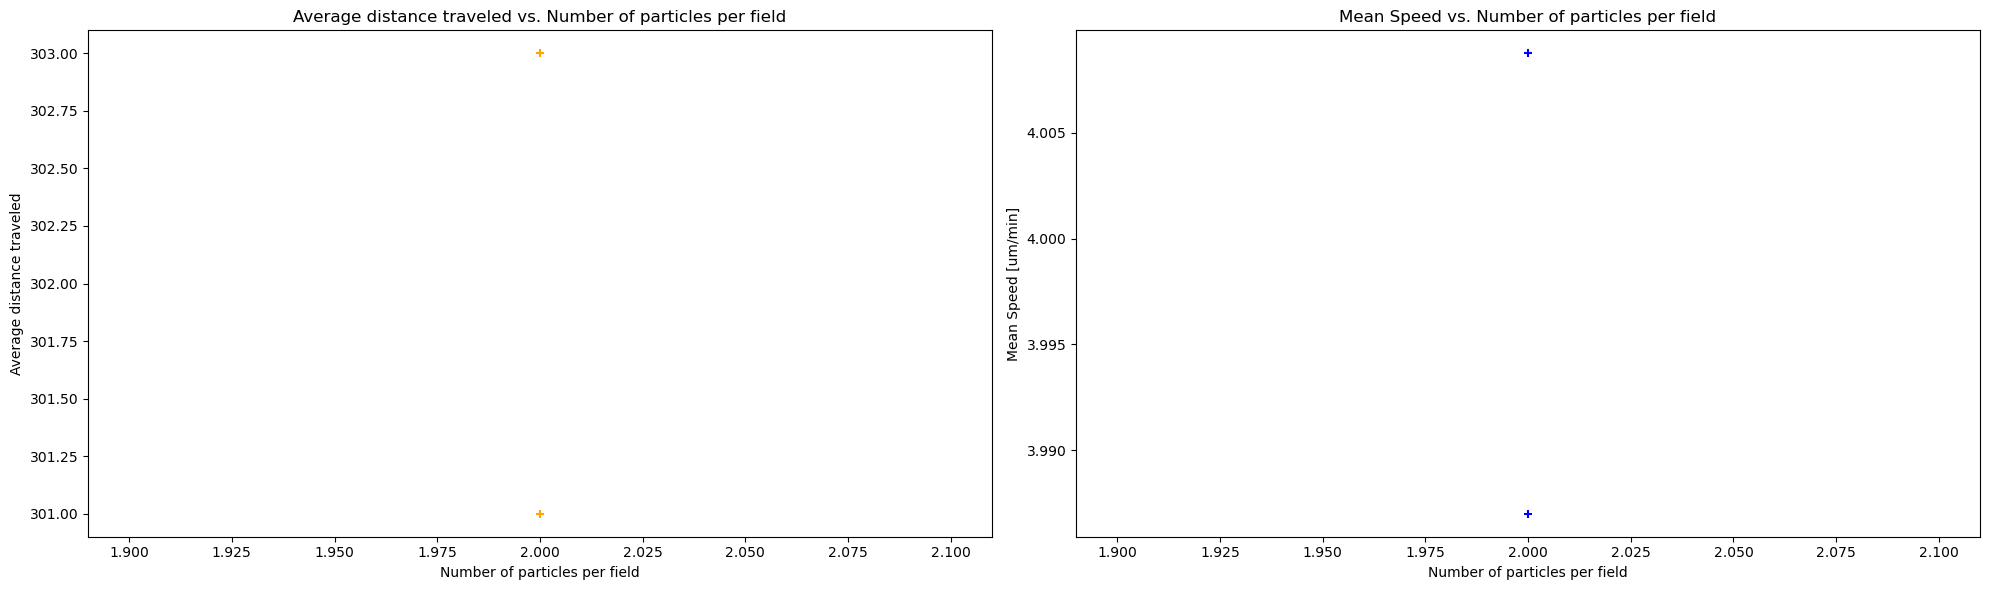

In [430]:
import matplotlib.pyplot as plt

# Supposons que result_df est votre DataFrame contenant les données nécessaires

# Création d'une grille de sous-graphiques 2x2
fig, axes = plt.subplots(1, 2, figsize=(20, 6))  # Ajustez la taille selon vos besoins

# Aplatir le tableau d'axes pour un accès plus facile
ax1, ax2, = axes.flatten()

# Premier graphique: Mean Sum vs. Nombre de Particules par Champ
ax1.scatter(result_df['nombre_part_par_champs'], result_df['mean_sum'], marker='+', color='orange')
ax1.set_title('Average distance traveled vs. Number of particles per field')
ax1.set_xlabel('Number of particles per field')
ax1.set_ylabel('Average distance traveled')

# Deuxième graphique: Mean Speed vs. Nombre de Particules par Champ
ax2.scatter(result_df['nombre_part_par_champs'], result_df['mean_speed [um/min]'], marker='+', color='blue')
ax2.set_title('Mean Speed vs. Number of particles per field')
ax2.set_xlabel('Number of particles per field')
ax2.set_ylabel('Mean Speed [um/min]')

# # Masquer le quatrième axe car il n'est pas utilisé
# ax4.axis('off')

# Ajustement de la mise en page pour éviter le chevauchement des titres
plt.tight_layout()

# Afficher les graphiques
plt.show()

fig.savefig(path_save_pic + f"graph in function of nbr of particles per field {CONDITION_simple}.png", format='png') 

In [431]:
path=filtered_DATA[filtered_DATA['particle']==filtered_DATA['particle'].unique()[0]]['experiment'].iloc[0]
import glob
glob.glob(f'/Users/souchaud/Desktop/A_analyser/CytoOne_HL5_10x_faits/*{path}*')
path

'ASMOT109'

In [432]:
filtered_DATA[filtered_DATA['particle']==filtered_DATA['particle'].unique()[0]]['experiment'].iloc[0]

'ASMOT109'

In [433]:
DATA['experiment'].unique()

array(['ASMOT109', 'ASMOT901'], dtype=object)

In [434]:
DATA.columns

Index(['index', 'y', 'x', 'mass', 'size', 'ecc', 'signal', 'raw_mass', 'ep',
       'frame', 'old_particle', 'count', 'particle', 'experiment', 'position',
       'condition', 'time (min)', 'dx [pix]', 'dy [pix]', 'displacement [pix]',
       'VitInst [um/min]', 'total_path_first_n', 'Xc [pix]', 'Yc [pix]',
       'cumulative displacement [um]', 'dx', 'dy'],
      dtype='object')

In [435]:
DATA[(DATA['frame'] == 0) & (DATA['y'] >= 2500) & (DATA['y'] <= 2800) & (DATA['raw_mass'] > 5000)]


,index,y,x,mass,size,ecc,signal,raw_mass,ep,frame,...,dx [pix],dy [pix],displacement [pix],VitInst [um/min],total_path_first_n,Xc [pix],Yc [pix],cumulative displacement [um],dx,dy


In [436]:
DATA.columns

Index(['index', 'y', 'x', 'mass', 'size', 'ecc', 'signal', 'raw_mass', 'ep',
       'frame', 'old_particle', 'count', 'particle', 'experiment', 'position',
       'condition', 'time (min)', 'dx [pix]', 'dy [pix]', 'displacement [pix]',
       'VitInst [um/min]', 'total_path_first_n', 'Xc [pix]', 'Yc [pix]',
       'cumulative displacement [um]', 'dx', 'dy'],
      dtype='object')

(array([  1.,   1.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   1.,   2.,   0.,   2.,   0.,   0.,   1.,   0.,   4.,
          1.,   1.,   2.,   0.,   1.,   4.,   0.,   4.,   1.,   0.,   2.,
          2.,   1.,   2.,   1.,   1.,   1.,   1.,   3.,   2.,   1.,   3.,
          2.,   5.,   3.,   3.,   2.,   7.,   4.,   1.,   1.,   0.,   3.,
          3.,   3.,   0.,   5.,   5.,   6.,   1.,   5.,   7.,   3.,   4.,
          4.,   6.,   7.,   6.,   8.,   7.,   5.,   5.,  10.,   7.,   5.,
          4.,   8.,   6.,   7.,   6.,   9.,  16.,  13.,   4.,   8.,   9.,
         15.,  12.,  15.,  17.,  12.,   8.,  11.,  12.,  13.,  10.,  14.,
         27.,  14.,  25.,  22.,  32.,  33.,  24.,  32.,  31.,  28.,  35.,
         22.,  28.,  33.,  18.,  39.,  24.,  39.,  22.,  37.,  36.,  38.,
         47.,  36.,  49.,  39.,  44.,  44.,  42.,  56.,  46.,  54.,  56.,
         56.,  63.,  50.,  71.,  54.,  60.,  69.,  65.,  58.,  68.,  69.,
         64.,  57.,  57.,  84.,  61., 

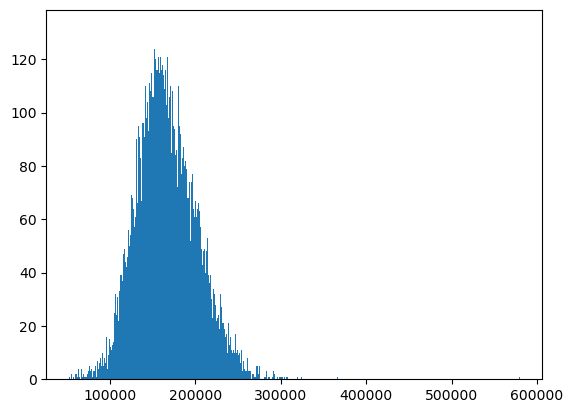

In [437]:
df = DATA[(DATA['raw_mass'] > 50000)]
plt.hist(df['raw_mass'], bins=1000)

(array([ 27.,  58.,  93., 109., 145., 185., 173., 206., 226., 244., 255.,
        281., 278., 304., 304., 293., 261., 272., 255., 266., 243., 292.,
        324., 277., 261., 265., 277., 253., 244., 255., 224., 234., 216.,
        247., 238., 232., 232., 205., 197., 201., 185., 189., 185., 173.,
        178., 183., 180., 157., 168., 157., 170., 155., 130., 162., 144.,
        129., 134., 123., 131., 115., 137., 114., 135., 126., 137., 101.,
        124., 113., 118., 106., 116.,  97., 104.,  89.,  96.,  92.,  82.,
         79.,  77.,  77.,  69.,  78.,  71.,  90.,  71.,  75.,  78.,  70.,
         82.,  73.,  60.,  73.,  72.,  67.,  62.,  64.,  62.,  61.,  61.,
         46.,  44.,  28.,  40.,  57.,  55.,  51.,  39.,  39.,  55.,  46.,
         47.,  46.,  36.,  45.,  38.,  42.,  31.,  35.,  35.,  36.,  38.,
         23.,  30.,  36.,  39.,  23.,  34.,  33.,  26.,  32.,  31.,  23.,
         24.,  22.,  24.,  31.,  38.,  21.,  23.,  18.,  24.,  25.,  37.,
         20.,  34.,  16.,  30.,  25., 

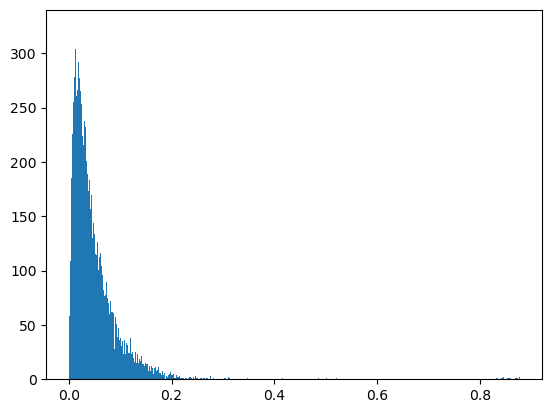

In [438]:
plt.hist(DATA['ecc'], bins=1000)

In [439]:
DATA.columns

Index(['index', 'y', 'x', 'mass', 'size', 'ecc', 'signal', 'raw_mass', 'ep',
       'frame', 'old_particle', 'count', 'particle', 'experiment', 'position',
       'condition', 'time (min)', 'dx [pix]', 'dy [pix]', 'displacement [pix]',
       'VitInst [um/min]', 'total_path_first_n', 'Xc [pix]', 'Yc [pix]',
       'cumulative displacement [um]', 'dx', 'dy'],
      dtype='object')